In [1]:
##this notebook is created by soumyajit saha in kaggle environment based on 
##amex defaultprediction dataset on 27022023

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/american-express-default-prediction/amex-default-prediction/sample_submission.csv
/kaggle/input/american-express-default-prediction/amex-default-prediction/test.feather
/kaggle/input/american-express-default-prediction/amex-default-prediction/train_labels.csv
/kaggle/input/american-express-default-prediction/amex-default-prediction/train.feather


In [2]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import export_graphviz
import matplotlib as mp
import matplotlib.pyplot as plt
import graphviz as gp
from sklearn import decomposition as dcp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score,mean_squared_error, confusion_matrix

# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)  # Show all columns


## about the data 

The objective of this analysis is to predict the probability that a customer might or will not pay back their credit card balance amount in the future based on their monthly customer profile. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

D_* = Delinquency variables

S_* = Spend variables

P_* = Payment variables

B_* = Balance variables

R_* = Risk variables with the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

Your task is to predict, for each customer_ID, the probability of a future payment default (target = 1).

Note that the negative class has been subsampled for this dataset at 5%, and thus receives a 20x weighting in the scoring metric

train_data.csv - training data with multiple statement dates per customer_ID train_labels.csv - target label for each customer_ID test_data.csv - corresponding test data; your objective is to predict the target label for each customer_ID sample_submission.csv - a sample submission file in the correct format



In [3]:
#loading the training dataset
filepath='/kaggle/input/american-express-default-prediction/amex-default-prediction/train.feather'
df_train=pd.read_feather(filepath)

In [4]:
df_train.info() #checking data quality

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: float16(177), int8(11), object(2)
memory usage: 2.0+ GB


In [5]:
df_train.head() # see how most of the column looks like

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,NaN,NaN,0.000630,0.080994,0.708984,0.170654,0.006203,0.358643,0.525391,0.255615,NaN,0.063904,0.059418,0.006466,0.148682,1.335938,0.008209,0.001423,0.207275,0.736328,0.096191,NaN,0.023376,0.002768,0.008324,1.001953,0.008301,0.161377,0.148315,0.922852,0.354492,0.151978,0.118103,0.001882,0.158569,0.065735,0.018387,0.063660,0.199585,0.308350,0.016357,0.401611,0.091064,0,1,0.007126,0.007664,NaN,0.652832,0.008522,-1,0.004730,6,0.271973,0.008362,0.515137,0.002644,0.009010,0.004807,0.008339,0.119385,0.004803,0.108276,0.050873,NaN,0.007553,0.080444,0.069092,NaN,0.004326,0.007561,NaN,0.007729,0.000272,0.001575,0.004238,0.001434,NaN,0.002272,0.004059,0.007122,0.002457,0.002310,0.003532,0.506836,0.008034,1.009766,0.084656,0.003820,0.007042,0.000438,0.006451,0.000830,0.005054,NaN,0,0.005722,0.007084,NaN,0.000198,0.008911,NaN,1.0,0.002537,0.005177,0.006626,0.009705,0.007782,0.002449,1.000977,0.002665,0.007481,0.006893,1.503906,1.005859,0.003569,0.008873,0.003948,0.003647,0.004951,0.894043,0.135620,0.911133,0.974609,0.001244,0.766602,1.008789,1.004883,0.893555,NaN,0.669922,0.009972,0.004570,NaN,1.008789,2,NaN,0.004326,NaN,NaN,NaN,1.007812,0.210083,0.676758,0.007874,1,0.238281,0,4,0.232178,0.236206,0,0.702148,0.434326,0.003057,0.686523,0.008743,1,1.002930,1.007812,1.000000,0.006805,NaN,0.002052,0.005970,NaN,0.004345,0.001534,NaN,NaN,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,NaN,NaN,0.002525,0.069397,0.712891,0.113220,0.006207,0.353516,0.521484,0.223389,NaN,0.065247,0.057739,0.001614,0.149780,1.339844,0.008369,0.001984,0.202759,0.720703,0.099792,NaN,0.030594,0.002748,0.002481,1.008789,0.005135,0.140991,0.143555,0.919434,0.326660,0.156250,0.118713,0.001610,0.148438,0.093933,0.013039,0.065491,0.151367,0.265137,0.017685,0.406250,0.086792,0,1,0.002413,0.007149,NaN,0.646973,0.002237,-1,0.003880,6,0.188965,0.004028,0.509277,0.004192,0.007843,0.001283,0.006523,0.140625,0.000094,0.101013,0.040466,NaN,0.004833,0.081421,0.074158,NaN,0.004204,0.005302,NaN,0.001864,0.000978,0.009895,0.007599,0.000509,NaN,0.009811,0.000126,0.005966,0.000395,0.001327,0.007774,0.500977,0.000761,1.009766,0.081848,0.000347,0.007790,0.004311,0.002333,0.009468,0.003754,NaN,0,0.007584,0.006676,NaN,0.001143,0.005905,NaN,1.0,0.008430,0.008980,0.001854,0.009926,0.005989,0.002247,1.006836,0.002508,0.006828,0.002836,1.503906,1.005859,0.000571,0.000391,0.008354,0.008850,0.003180,0.902344,0.136353,0.919922,0.975586,0.004562,0.786133,1.000000,1.003906,0.906738,NaN,0.668457,0.003922,0.004654,NaN,1.002930,2,NaN,0.008705,NaN,NaN,NaN,1.007812,0.184082,0.822266,0.003445,1,0.247192,0,4,0.243530,0.241943,0,0.707031,0.430420,0.001306,0.686523,0.000755,1,1.008789,1.003906,1.008789,0.004406,NaN,0.001034,0.004837,NaN,0.007496,0.004932,NaN,NaN,NaN,NaN,

load the labels containing default or no default info and the sample submission file as available in case of most kaggle dataset

In [6]:
df_trainlabels=pd.read_csv('/kaggle/input/american-express-default-prediction/amex-default-prediction/train_labels.csv')
df_sample_submission=pd.read_csv('/kaggle/input/american-express-default-prediction/amex-default-prediction/sample_submission.csv')

In [7]:
df_trainlabels.groupby('target').size()


target
0    340085
1    118828
dtype: int64

In [8]:
340085/df_trainlabels.shape[0]

0.7410663894899469

In [9]:
df_trainlabels.shape #there is a mismatch between number of rows in  train dataset and label dataset 
# meaning there might be customer id repeating in the train data

(458913, 2)

In [10]:
#filepath='/kaggle/input/american-express-default-prediction/amex-default-prediction/test.feather'
#test_df=pd.read_feather(filepath) #keep the test data loaded for later

the info on the dataset tells us that the actual column names were masked and they were presented under a particular aplhabet based on their type, eg. D_ for delinquency variables and so on...so first let us define a function to sort the columns alphabetically

In [11]:
def sort_columns_alphabetically(df):
    # Extract the customer_ID column
    customer_id_col = df.iloc[:, 0]

    # Sort the remaining columns alphabetically
    sorted_cols = sorted(df.columns[1:])

    # Concatenate the customer_ID column with the sorted columns
    sorted_df = pd.concat([customer_id_col, df[sorted_cols]], axis=1)

    return sorted_df

In [12]:
df_train=sort_columns_alphabetically(df_train)
df_train.head()

,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_2,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.008728,0.096191,0.002768,0.148315,0.118103,0.018387,0.016357,0.007664,NaN,0.652832,0.008522,1.006836,0.004730,0.002644,0.004807,0.050873,0.004326,0.007729,0.000272,0.002310,0.084656,NaN,0.004707,0,1.0,0.006626,1.000977,0.009972,0.004570,2,NaN,0.080994,0.210083,0.006805,NaN,0.170654,0.063904,0.059418,0.006466,0.008209,0.766602,1.008789,1.004883,0.893555,NaN,0.669922,NaN,0.004326,NaN,NaN,1.007812,0.007874,1,0.238281,0,4,0.232178,0.236206,0,0.702148,0.434326,0.003057,0.686523,0.008743,1,1.002930,1.007812,1.000000,0.002052,0.005970,NaN,0.004345,NaN,NaN,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0.001734,0.008774,NaN,NaN,0.000630,0.708984,0.358643,0.525391,0.255615,NaN,0.148682,1.335938,0.207275,NaN,1.001953,0.354492,0.151978,0.158569,0.063660,0.199585,0.308350,0.091064,0,1,0.007126,-1,6,0.009010,0.008339,0.119385,0.004803,NaN,0.080444,0.069092,NaN,NaN,0.001575,0.004238,0.004059,0.003532,0.506836,0.007042,0.000830,0.007084,NaN,NaN,0.002665,1.503906,1.005859,0.003569,0.008873,0.004951,0.938477,0.736328,0.007553,0.009224,0.007122,0.002457,1.009766,0.003820,0.000438,0.006451,0.005054,0.000198,0.008911,0.005177,0.006203,0.007782,0.002449,0.007481,0.006893,0.003948,0.003647,NaN,1.008789,0.001534,0.001423,0.008301,0.001882,0.008362,0.007561,0.001434,NaN,0.401611,0.271973,0.515137,0.108276,0.002272,0.008034,0.005722,0.002537,2017-03-09,0.009705,0.894043,0.135620,0.911133,0.974609,0.001244,0.676758,0.124023,0.023376,0.008324,0.161377,0.922852,0.065735
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.004925,0.099792,0.002748,0.143555,0.118713,0.013039,0.017685,0.007149,NaN,0.646973,0.002237,1.000977,0.003880,0.004192,0.001283,0.040466,0.004204,0.001864,0.000978,0.001327,0.081848,NaN,0.002714,0,1.0,0.001854,1.006836,0.003922,0.004654,2,NaN,0.069397,0.184082,0.004406,NaN,0.113220,0.065247,0.057739,0.001614,0.008369,0.786133,1.000000,1.003906,0.906738,NaN,0.668457,NaN,0.008705,NaN,NaN,1.007812,0.003445,1,0.247192,0,4,0.243530,0.241943,0,0.707031,0.430420,0.001306,0.686523,0.000755,1,1.008789,1.003906,1.008789,0.001034,0.004837,NaN,0.007496,NaN,NaN,NaN,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0.005775,0.000798,NaN,NaN,0.002525,0.712891,0.353516,0.521484,0.223389,NaN,0.149780,1.339844,0.202759,NaN,1.008789,0.326660,0.156250,0.148438,0.065491,0.151367,0.265137,0.086792,0,1,0.002413,-1,6,0.007843,0.006523,0.140625,0.000094,NaN,0.081421,0.074158,NaN,NaN,0.009895,0.007599,0.000126,0.007774,0.500977,0.007790,0.009468,0.006676,NaN,NaN,0.002508,1.503906,1.005859,0.000571,0.000391,0.003180,0.936523,0.720703,0.004833,0.006153,0.005966,0.000395,1.009766,0.000347,0.004311,0.002333,0.003754,0.001143,0.005905,0.008980,0.006207,0.005989,0.002247,0.006828,0.002836,0.008354,0.008850,NaN,1.002930,0.004932,0.001984,0.005135,0.001610,0.004028,0.005302,0.000509,NaN,0.406250,0.188965,0.509277,0.101013,0.009811,0.000761,0.007584,0.008430,2017-04-07,0.009926,0.902344,0.136353,0.919922,0.975586,0.004562,0

In [13]:
df_train.shape[0]

5531451

In [14]:
len(np.unique(df_train["customer_ID"]))

458913

we can see that number of unique ids are way less than number of rows but equals the number of rows in the label data so there must be more than one row for some ids, lets find out

In [15]:
# Group by 'customer_ID' and count occurrences, then reset index and rename the count column
id_counts = df_train.groupby('customer_ID').size().reset_index(name='ID_count')

# Count occurrences of each ID_count value and reset index, rename columns for readability
count_distribution = id_counts['ID_count'].value_counts().reset_index(name="occurrences")

print(count_distribution)


    ID_count  occurrences
0         13       386034
1         12        10623
2         10         6721
3          9         6411
4          8         6110
5          2         6098
6         11         5961
7          3         5778
8          6         5515
9          7         5198
10         1         5120
11         4         4673
12         5         4671


In [16]:
sum(count_distribution["occurrences"])==len(np.unique(df_train["customer_ID"]))

True

In [17]:
count_distribution["occurrences"]=count_distribution["occurrences"]/len(np.unique(df_train["customer_ID"]))
count_distribution.sort_values(by="occurrences", ascending=False, inplace=True)
count_distribution

,ID_count,occurrences
0,13,0.841192
1,12,0.023148
2,10,0.014645
3,9,0.013970
4,8,0.013314
5,2,0.013288
6,11,0.012989
7,3,0.012591
8,6,0.012018
9,7,0.011327


This begs a question as to how data points are different from each other where more than rows of data are availavble. We can check for duplicates and na values now

In [18]:
import pandas as pd

def check_data_quality(data):
    # Check for duplicate rows
    duplicate_rows = data[data.duplicated()]
    
    # Check for missing values
    missing_values = data.isnull().sum()
    
    # Get data types
    data_types = data.dtypes
    
    # Get unique value counts
    unique_val_count = data.nunique()
    
    # Combine all information into a DataFrame
    column_info = pd.DataFrame({
        "Column": data.columns,
        "Data_Type": data_types,
        "Missing_Values": missing_values.astype(bool),
        "Missing_Count": missing_values,
        "unique_val_count": unique_val_count
    })
    
    # Return the results
    if len(duplicate_rows) > 0:
        print("Duplicate Rows Found:\n", duplicate_rows)
    else:
        print("No Duplicate Rows Found.")
    print("Shape of the data is:", data.shape)
    
    return column_info


In [19]:
%%time
train_data_quality=check_data_quality(df_train)
train_data_quality

No Duplicate Rows Found.
Shape of the data is: (5531451, 190)
CPU times: user 56.3 s, sys: 12 s, total: 1min 8s
Wall time: 1min 8s


,Column,Data_Type,Missing_Values,Missing_Count,unique_val_count
customer_ID,customer_ID,object,False,0,458913
B_1,B_1,float16,False,0,22627
B_10,B_10,float16,False,0,22847
B_11,B_11,float16,False,0,15937
B_12,B_12,float16,False,0,18847
...,...,...,...,...,...
S_5,S_5,float16,False,0,19124
S_6,S_6,float16,False,0,8491
S_7,S_7,float16,True,1020544,20625
S_8,S_8,float16,False,0,9499


In [20]:
# Filter rows where Missing_Count is not equal to 0 and select specific columns
na_df=train_data_quality.loc[train_data_quality['Missing_Count'] != 0, ['Column', 'Missing_Count']].sort_values(by="Missing_Count", ascending=False)
na_df['Missing_Count']=na_df['Missing_Count']/df_train.shape[0]*100
na_df

,Column,Missing_Count
D_87,D_87,99.930127
D_88,D_88,99.891457
D_108,D_108,99.476846
D_111,D_111,99.433530
D_110,D_110,99.433530
...,...,...
R_12,R_12,0.001012
B_37,B_37,0.001012
B_40,B_40,0.000958
R_7,R_7,0.000018


1.we can see that some columns have na values in more than 99% of the cases
2.imputation of values will contaminate the data set further 
3.Outright deletion is also a bad option as we do not have explanantion of individual columns
4.Feature importance criteria from ensemble metheods like lgbm or random forest might give us an idea on how influencial one particular feature is and based on that we can delete some columns


there are 112 columns with missing data 

In [21]:
int_columns = train_data_quality[train_data_quality['Data_Type'] == 'int8']['Column'].tolist()
obj_columns=train_data_quality[train_data_quality['Data_Type'] == 'object']['Column'].tolist()
#collecting int type and object type column names

In [22]:
df_train[int_columns].head()

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_66,D_68
0,0,2,1,0,4,0,1,0,1,-1,6
1,0,2,1,0,4,0,1,0,1,-1,6
2,0,2,1,0,4,0,1,0,1,-1,6
3,0,2,1,0,4,0,1,0,1,-1,6
4,0,2,1,0,4,0,1,0,1,-1,6


In [23]:
df_train[int_columns].apply(lambda x: (x.nunique(), x.unique()))


,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_66,D_68
0,4,8,3,3,7,3,3,6,5,3,8
1,"[0, 2, 1, -1]","[2, 1, 3, 5, 6, 7, 4, -1]","[1, 0, -1]","[0, -1, 1]","[4, -1, 6, 2, 1, 3, 5]","[0, 1, -1]","[1, -1, 0]","[0, 1, 2, 3, 4, 5]","[1, 2, -1, 3, 0]","[-1, 1, 0]","[6, 2, 3, -1, 5, 4, 0, 1]"


We can see that integer type variables are essentially category variables and we can leave them out standardization. However, there might be other category variable, to check that we can filter the columns based on unique value counts.

In [24]:
train_data_quality.sort_values(by="unique_val_count",).head(20)

,Column,Data_Type,Missing_Values,Missing_Count,unique_val_count
D_87,D_87,float16,True,5527586,1
B_31,B_31,float16,False,0,2
D_126,D_126,int8,False,0,3
D_66,D_66,int8,False,0,3
D_114,D_114,int8,False,0,3
D_116,D_116,int8,False,0,3
D_120,D_120,int8,False,0,3
B_30,B_30,int8,False,0,4
D_64,D_64,int8,False,0,5
D_63,D_63,int8,False,0,6


In [25]:
# Filter rows where Unique_Value_Count is less than 10 and select specific columns
filtered_data = train_data_quality[train_data_quality['unique_val_count'] < 10]

# Get the column names where Unique_Value_Count is less than 10
columns_to_check = filtered_data['Column'].tolist()

# Display unique values for each selected column
for column in columns_to_check:
    unique_values = df_train[column].unique()
    print(f"Unique values for column '{column}': {unique_values}")


Unique values for column 'B_30': [ 0  2  1 -1]
Unique values for column 'B_31': [1. 0.]
Unique values for column 'B_38': [ 2  1  3  5  6  7  4 -1]
Unique values for column 'D_114': [ 1  0 -1]
Unique values for column 'D_116': [ 0 -1  1]
Unique values for column 'D_117': [ 4 -1  6  2  1  3  5]
Unique values for column 'D_120': [ 0  1 -1]
Unique values for column 'D_126': [ 1 -1  0]
Unique values for column 'D_63': [0 1 2 3 4 5]
Unique values for column 'D_64': [ 1  2 -1  3  0]
Unique values for column 'D_66': [-1  1  0]
Unique values for column 'D_68': [ 6  2  3 -1  5  4  0  1]
Unique values for column 'D_87': [nan  1.]


from here we can see that B_30 and D_87 only have float type as data type but looks like categorical. D_87's NA values can be treated as a seperate category and that will resolve NA issue for this particular column

In [26]:
df_train['D_87'] = df_train['D_87'].fillna(0)

so now columns_to_check contains list of categorical columns

In [27]:
#now lets check the object columns
df_train[obj_columns].head()

,customer_ID,S_2
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16


the s2 column looks like a date and it is not in datetime format so that is why it is like a object,

In [28]:
df_train['S_2'] = pd.to_datetime(df_train['S_2'])



In [29]:
float_columns = list(filter(lambda x: x not in columns_to_check and x not in obj_columns, df_train.columns))

In [30]:
len(float_columns),df_train[float_columns].max(),df_train[float_columns].min()

(175,
 B_1        1.324219
 B_10    4096.000000
 B_11       1.970703
 B_12     420.750000
 B_13     276.250000
            ...     
 S_5      206.875000
 S_6        1.009766
 S_7        3.949219
 S_8        1.231445
 S_9        2.839844
 Length: 175, dtype: float16,
 B_1    -7.589844e+00
 B_10   -2.958298e-03
 B_11    0.000000e+00
 B_12    5.960464e-08
 B_13    0.000000e+00
             ...     
 S_5     0.000000e+00
 S_6     0.000000e+00
 S_7    -4.702148e-01
 S_8     0.000000e+00
 S_9     2.980232e-07
 Length: 175, dtype: float16)

Now, we saw there are customer id s with 13 repetition  I want to check one customer id data points from each 

In [31]:
customer_id_counts=df_train.groupby('customer_ID').size().reset_index(name='ID_count')

# Getting unique counts of occurrences
unique_counts = sorted(customer_id_counts['ID_count'].unique())

# Dictionary to store customer IDs for each count
customer_ids_dict = {}

# Collecting two customer IDs for each count category
for count in unique_counts:
    # Filtering customer IDs with the current count
    customer_ids = customer_id_counts[customer_id_counts['ID_count'] == count]['customer_ID'].tolist()[:1]
    customer_ids_dict[count] = customer_ids



In [32]:
# Dictionary to store dataframes for each pair of customer IDs
dataframes_dict = {}

# Filtering and storing dataframes for each pair of customer IDs
for count, customer_ids in customer_ids_dict.items():
    dataframes_list = []
    for customer_id in customer_ids:
        # Filtering rows for the current customer ID
        filtered_df = df_train[df_train['customer_ID'] == customer_id]
        dataframes_list.append(filtered_df)
    # Storing the pair of dataframes in the dictionary
    dataframes_dict[count] = dataframes_list

from IPython.display import display

for count, dataframes_list in dataframes_dict.items():
    print(f"Category with {count} occurrences:")
    for i, df in enumerate(dataframes_list):
        print(f"\nCustomer ID {i + 1} ({customer_ids_dict[count][i]}):")
        display(df)
        print("-" * 50)



Category with 1 occurrences:

Customer ID 1 (0009bd8871169b8d76a445e1f52079a6edc0b6f0bf021d5ec50ef6aa6487cc14):


,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_2,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
762,0009bd8871169b8d76a445e1f52079a6edc0b6f0bf021d...,0.003712,0.028748,0.003662,0.010628,0.006496,0.001786,0.009514,0.002693,NaN,0.585449,0.006256,0.815918,0.006237,0.009583,0.006916,0.211914,0.008423,0.002577,0.001046,0.008514,0.140869,NaN,0.000327,0,1.0,0.008415,1.006836,0.009651,0.005642,1,NaN,0.137939,0.094849,0.008057,NaN,0.007317,0.179565,0.228882,1.008789,0.00975,0.811035,1.003906,0.985352,0.512695,NaN,0.336426,NaN,0.00449,NaN,NaN,1.001953,NaN,-1,NaN,-1,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,0,0.009781,0.999512,0.0051,0.002419,0.000184,NaN,0.00404,NaN,NaN,NaN,NaN,NaN,0.000577,0.005505,0.001053,NaN,0.003975,0.007179,0.00827,0.007034,0.008011,0.052399,NaN,0.131836,0.011223,NaN,0.555664,0.478271,NaN,NaN,0.008858,0.111633,0.189331,1.009766,0.151489,NaN,0.474121,0.506348,0.001742,0.770508,0.017654,1,-1,0.005825,-1,-1,NaN,0.001533,0.026947,0.343262,NaN,0.287842,0.276611,0.002295,0.017883,0.002798,0.001637,0.009766,0.006668,NaN,NaN,0.504883,0.009766,0.0,NaN,0.005974,0.003595,0.005985,0.006824,0.00123,0.003506,0.286133,NaN,0.959961,0.507812,0.005379,0.007175,1.004883,0.00256,0.001873,0.00093,0.00407,0.00251,0.001234,0.004017,1.000977,0.008713,0.002895,0.009056,0.002214,0.001069,0.005791,NaN,NaN,0.006741,0.500488,1.005859,0.502441,0.126221,0.143677,1.006836,NaN,0.287109,0.185303,0.004589,0.507324,0.00457,0.007401,0.003437,0.000541,2018-03-24,0.009377,0.353516,0.137817,0.158447,0.973633,0.006912,NaN,NaN,0.004803,1.004883,NaN,0.002523,NaN


--------------------------------------------------
Category with 2 occurrences:

Customer ID 1 (0005ef1480ffe4f0e5908eae07db8e05f2e705bca6a57db3b97d1da2eb6c7cab):


,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_2,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
456,0005ef1480ffe4f0e5908eae07db8e05f2e705bca6a57d...,1.322266,0.068176,1.368164,0.011284,0.265625,0.405762,0.005257,0.335449,0.930176,0.094788,0.574219,0.031403,0.242432,0.006676,0.509766,0.256104,0.004822,0.711426,0.002752,0.009537,0.450684,NaN,0.302246,1,1.0,0.008179,0.00449,0.000296,1.325195,7,NaN,0.285645,0.144897,0.007397,NaN,0.006783,0.051758,0.254150,NaN,0.826660,0.034515,1.002930,0.954102,0.087646,NaN,0.343018,NaN,0.004253,NaN,NaN,1.000000,0.803711,1,0.521973,0,3,0.511719,0.516602,0,0.457031,0.288086,0.004143,0.550293,0.000916,1,0.007507,1.004883,0.009155,0.008949,0.00149,NaN,0.004337,NaN,NaN,NaN,NaN,NaN,0.006817,0.007206,0.001205,NaN,0.001641,0.009781,0.003469,0.031708,0.005791,NaN,0.138428,0.504395,0.136719,1.296875,0.239258,0.973633,NaN,NaN,0.000327,0.165527,0.224609,1.003906,0.562500,NaN,0.174561,NaN,0.414551,0.579102,0.111755,1,1,0.008705,1,6,0.008949,0.501953,0.006046,0.337402,NaN,0.143677,0.207397,NaN,0.107666,2.005859,0.00901,1.007812,0.009689,NaN,0.004246,0.503906,0.004173,0.0,NaN,0.000441,0.005013,0.004898,0.004520,0.009254,0.001637,0.186768,-0.027969,0.005989,0.503906,0.004524,0.000741,1.004883,0.007843,0.000758,0.006458,0.007236,0.009895,0.006763,0.006279,1.006836,0.001398,0.007820,0.007309,0.000738,0.007725,0.008987,NaN,NaN,0.000477,0.108276,1.003906,0.500488,0.739258,0.857422,1.003906,NaN,0.289551,0.186035,0.001919,0.509277,0.005875,0.002472,0.008537,0.006809,2018-02-13,0.006180,0.344971,0.136475,0.155029,0.979004,0.005325,NaN,NaN,0.008163,1.003906,NaN,0.001158,NaN
457,0005ef1480ffe4f0e5908eae07db8e05f2e705bca6a57d...,1.318359,0.011795,1.369141,0.008667,0.267090,0.410889,0.008919,0.426270,1.006836,0.001544,0.577148,0.000749,0.303955,0.009132,0.501465,0.898926,0.001581,0.723145,0.003876,0.008987,0.684570,NaN,0.260498,1,1.0,0.006687,0.00528,0.000843,1.325195,7,NaN,0.445068,0.308105,0.005859,NaN,0.006435,0.008797,0.842285,NaN,0.833496,0.060913,1.001953,0.958496,0.109497,NaN,0.340088,NaN,0.006798,NaN,NaN,1.008789,1.006836,1,0.013824,0,-1,0.513672,0.512695,0,0.467285,0.149658,0.005817,0.597168,0.002609,1,0.002836,1.009766,0.003134,0.001853,0.00444,NaN,0.003698,NaN,NaN,NaN,NaN,NaN,0.004734,0.008118,0.004822,NaN,0.003048,0.001506,0.008163,0.914551,0.005856,NaN,0.132690,0.384277,0.137817,0.607910,0.246582,0.973145,NaN,NaN,0.007790,0.165161,0.590820,1.000000,0.647461,NaN,0.680176,0.547852,0.275391,0.939453,0.072327,1,3,0.000983,1,5,0.000974,0.759766,0.007462,0.336914,NaN,0.357666,0.400879,NaN,NaN,1.507812,0.00732,1.005859,0.004597,NaN,0.000932,0.505859,0.005470,0.0,NaN,0.002146,0.001760,0.005554,0.001607,0.009483,0.008911,0.068481,-0.291748,0.002506,0.753906,0.000958,0.009018,1.008789,0.073364,0.003820,0.005013,0.007015,0.009590,0.002050,1.000977,1.000977,0.002972,0.007568,0.009361,0.007587,0.003082,0.006603,NaN,NaN,0.008949,0.005810,1.003906,4.007812,3.826172,4.468750,6.007812,NaN,0.287354,0.184570,0.004848,0.501465,0.000690,0.006718,0.008759,0.000607,2018-03-16,0.007221,0.353516,0.137207,0.182495,0.976074,0.008232,NaN,NaN,0.001860,1.001953,NaN,0.003572,NaN

--------------------------------------------------
Category with 3 occurrences:

Customer ID 1 (0001337ded4e1c2539d1a78ff44a457bd4a95caa55ba1730b2849b92ea687f9e):


,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_2,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
130,0001337ded4e1c2539d1a78ff44a457bd4a95caa55ba17...,0.019287,0.244263,0.012680,0.007164,NaN,0.002321,0.000618,0.004944,NaN,1.002930,0.004257,0.819824,0.006290,0.005909,0.007191,0.011169,0.000810,0.006817,0.001648,0.004543,0.009834,NaN,0.007351,0,1.0,0.002468,1.008789,0.007263,0.019943,1,NaN,0.004898,0.008919,0.008965,NaN,0.008606,0.178345,0.027100,1.008789,0.032990,0.058929,1.000977,0.966309,0.192017,0.003296,0.335205,NaN,0.005878,NaN,NaN,1.006836,NaN,-1,NaN,-1,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,0,0.005180,0.008446,0.003345,1.000000,0.999023,0.310547,1.503906,NaN,NaN,NaN,NaN,NaN,1.007812,0.004372,0.874023,0.045441,1.009766,0.008591,0.098267,0.005257,0.004120,0.056213,NaN,NaN,0.005199,NaN,0.147095,NaN,0.008820,NaN,0.004173,0.037170,0.139160,1.000977,NaN,NaN,0.001703,NaN,1.003906,0.275879,NaN,1,-1,0.009247,-1,-1,NaN,NaN,0.013901,0.003443,NaN,0.005848,0.002348,NaN,0.005642,NaN,0.507812,0.006203,0.002502,NaN,NaN,0.009445,0.005833,0.0,NaN,0.002213,NaN,0.006638,0.001444,0.008934,0.000725,0.612305,NaN,0.962891,0.509766,0.008224,0.007526,1.005859,0.001130,0.008690,0.004059,0.009171,0.003990,0.000350,0.009537,1.009766,0.004864,0.005711,0.003658,0.009636,0.007698,0.004421,NaN,NaN,0.007572,0.205566,1.002930,0.506348,5.656250,3.300781,1.008789,NaN,0.365723,0.189209,0.009079,0.303711,0.003229,0.002323,0.008392,0.006744,2018-01-10,0.002583,0.915527,0.133179,0.902344,0.973145,0.009293,NaN,0.172241,0.016769,1.005859,0.163696,0.328857,NaN
131,0001337ded4e1c2539d1a78ff44a457bd4a95caa55ba17...,0.097839,0.302246,0.065125,0.006966,0.012360,0.018326,0.004360,0.005344,NaN,1.000977,0.000520,1.007812,0.001806,0.001817,0.009048,0.056732,0.009033,0.024323,0.009651,0.004719,0.013237,NaN,0.009933,0,1.0,0.000467,1.009766,0.002480,0.101013,1,NaN,0.013344,0.001256,0.007843,NaN,0.004745,0.194336,0.092896,1.002930,0.141724,0.036072,1.007812,0.960938,0.217773,0.009140,0.335693,NaN,0.009254,NaN,NaN,1.005859,NaN,-1,NaN,-1,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,0,0.002783,0.005428,0.001482,1.009766,1.000977,0.330566,1.507812,NaN,NaN,NaN,NaN,NaN,1.005859,0.004150,0.875488,0.056244,1.005859,0.009445,0.093140,0.241455,0.007866,0.054565,NaN,NaN,0.013245,NaN,0.152832,NaN,0.004841,NaN,0.001938,0.032593,0.165649,1.000977,NaN,NaN,0.001017,0.54248,1.005859,NaN,NaN,1,-1,0.003769,-1,-1,NaN,0.003374,0.014633,0.004654,NaN,0.006535,0.007881,NaN,NaN,NaN,0.500488,0.007469,1.005859,NaN,NaN,0.508301,0.005657,0.0,NaN,0.117188,NaN,0.004158,0.005955,0.004776,0.007671,0.254639,NaN,0.963867,1.003906,0.000216,0.007336,1.000000,0.035004,0.007843,1.000000,0.007442,0.008652,0.001047,0.009521,1.005859,0.006641,0.002634,0.002340,0.008820,0.000247,0.009720,NaN,NaN,0.005356,0.201172,1.008789,0.508789,5.761719,3.361328,0.009262,NaN,0.200562,0.186157,0.285889,0.601562,0.001289,0.006054,0.007778,0.004086,2018-02-22,0.006805,0.959473,0.136719,0.938965,0.973633,0.004555,0.002645,0.162231,0.012543,1.000000,0.223755,0.175293,NaN
132,0001337ded4e1c2539d1a78ff44a457bd4a95caa55ba17...,0.208618,0.301025,0.148438,0.003393,0.004871,0.030640,0.002018,0.0089

--------------------------------------------------
Category with 4 occurrences:

Customer ID 1 (000391f219520dbca6c3c1c46e0fab569da163f79ee266b2cc95fb31029ce617):


,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_2,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
250,000391f219520dbca6c3c1c46e0fab569da163f79ee266...,0.021439,0.002884,0.004013,0.009102,NaN,0.003925,0.009247,0.009575,NaN,0.645508,0.008522,0.814941,0.007614,0.005981,0.001987,0.316406,0.000814,0.005138,0.003883,0.007843,0.076355,NaN,0.000794,0,1.0,0.002760,1.009766,0.007504,0.014923,1,NaN,0.207520,0.144409,0.003538,NaN,0.007950,0.178833,0.376465,1.008789,0.014328,0.001860,NaN,NaN,NaN,NaN,NaN,NaN,0.008080,NaN,NaN,1.003906,NaN,-1,NaN,-1,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,0,0.001596,NaN,NaN,NaN,NaN,NaN,0.001550,NaN,NaN,NaN,NaN,NaN,NaN,0.001000,NaN,NaN,NaN,0.005745,NaN,0.003620,0.003891,0.037689,NaN,0.008118,0.007759,NaN,0.060455,0.443848,NaN,NaN,0.007866,0.143921,NaN,1.006836,0.003084,NaN,0.163330,NaN,0.012772,0.258057,0.060822,1,-1,0.005226,-1,-1,NaN,NaN,0.006996,0.002581,NaN,0.150269,0.139893,NaN,0.003689,0.001455,NaN,0.006187,0.006401,NaN,NaN,0.007561,0.002239,0.0,NaN,0.008881,NaN,0.000992,0.007355,0.007935,0.006199,0.619629,NaN,0.961426,0.006897,0.001255,0.001124,1.003906,0.006840,0.006687,0.005249,0.006458,0.009148,0.003242,0.009758,0.004974,0.008820,0.004066,0.003294,0.007713,0.002569,0.009514,NaN,NaN,0.004887,0.200684,0.000650,0.006477,0.008324,0.002085,0.001530,NaN,0.087280,0.189575,0.000129,1.102539,0.007950,0.006638,0.005455,0.005772,2017-12-29,0.002132,1.003906,0.138794,0.970215,0.972656,0.008118,NaN,0.319580,0.044891,1.000977,0.256104,0.106812,NaN
251,000391f219520dbca6c3c1c46e0fab569da163f79ee266...,0.035950,-0.002138,0.021240,0.011604,NaN,0.013641,0.004154,0.008423,NaN,0.651367,0.006424,0.815918,0.000834,0.003439,0.009148,0.327393,0.000119,0.015411,0.009361,0.009468,0.079102,NaN,0.006443,0,1.0,0.000025,1.003906,0.000150,0.038727,1,NaN,0.223999,0.146118,0.003489,NaN,0.009140,0.177124,0.391602,1.006836,0.046875,0.602051,1.005859,0.976074,0.460205,NaN,0.336182,NaN,0.003883,NaN,NaN,1.006836,NaN,-1,NaN,-1,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,0,0.000514,0.007526,0.000042,0.006729,0.001464,NaN,0.005409,NaN,NaN,NaN,NaN,NaN,0.005703,0.006065,0.004227,NaN,0.006462,0.004421,0.009605,0.002909,0.005043,0.039062,0.520508,0.003805,0.006073,NaN,0.062042,0.443359,NaN,NaN,0.007912,0.136475,NaN,1.004883,0.087585,NaN,0.160767,NaN,0.046173,0.250244,0.062378,1,-1,0.006569,-1,-1,NaN,NaN,0.014694,0.009140,NaN,0.148193,0.140869,NaN,0.007935,0.003328,0.004822,0.004387,0.003445,NaN,NaN,0.009056,0.001308,0.0,NaN,0.007927,NaN,0.002394,0.005058,0.002512,0.003511,0.625488,NaN,0.964844,0.007423,0.005203,0.006538,1.005859,0.001949,0.009140,0.004139,0.502930,0.006531,0.009583,0.008484,0.007179,0.002254,0.000643,0.006962,0.009773,0.008743,0.001760,NaN,NaN,0.009743,0.307129,0.006866,0.004669,0.003618,0.004349,0.002689,NaN,0.162598,0.192749,0.284912,0.901855,0.005650,0.009575,0.002647,0.006561,2018-01-01,0.004162,0.990234,0.134155,0.967773,0.973633,0.009438,NaN,0.566895,0.058777,1.003906,0.453613,0.175659,NaN
252,000391f219520dbca6c3c1c46e0fab569da163f79ee266...,0.135620,0.024673,0.097168,0.006542,0.030182,0.033173,0.004105,0.000803,NaN,0.646484,0.000776,0.815918,0.002056,0.004772,0.002951,0.26367

--------------------------------------------------
Category with 5 occurrences:

Customer ID 1 (002b66a636237d16b2344db6c39210bae5f091c9caf8479e6066101b4a197ce0):


,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_2,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
3526,002b66a636237d16b2344db6c39210bae5f091c9caf847...,0.010818,0.298340,0.002752,0.014526,NaN,0.007107,0.000126,0.008194,NaN,1.009766,0.005516,0.817871,0.004326,0.000056,0.004620,0.004158,0.009857,0.004608,0.007545,0.005413,0.012428,NaN,0.004700,0,1.0,0.009872,1.006836,0.001040,0.010178,1,NaN,0.005257,0.042572,0.002003,NaN,0.006023,0.177979,0.010574,1.006836,0.009537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005146,NaN,NaN,1.002930,NaN,-1,NaN,-1,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,-1,0.009933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007526,0.006035,0.091980,NaN,0.001136,0.000391,NaN,0.103455,0.217651,NaN,NaN,0.004311,0.030304,NaN,1.004883,0.003098,NaN,0.006485,NaN,0.061615,0.205200,0.041351,1,-1,0.000791,-1,-1,NaN,NaN,0.013451,0.000544,NaN,0.007298,0.005730,NaN,0.043976,0.002634,NaN,0.003525,0.004120,NaN,NaN,0.006443,0.007050,0.0,NaN,0.009338,NaN,0.001328,0.009583,0.005608,0.006916,0.526367,NaN,0.964844,0.003353,0.002058,0.004177,1.004883,0.004047,0.007038,0.001697,0.001972,0.001699,0.005978,0.006905,0.009384,0.004547,0.001387,0.009720,0.001153,0.009064,0.007095,NaN,1.002930,0.005146,0.310059,0.003305,0.002129,0.008171,0.005951,0.001034,NaN,0.363037,0.785645,0.005692,0.807617,0.003189,0.001514,0.006157,0.007629,2017-11-14,0.004822,0.794922,0.132812,0.763184,0.971191,0.002726,NaN,0.602539,0.007465,1.002930,0.475098,0.001465,NaN
3527,002b66a636237d16b2344db6c39210bae5f091c9caf847...,0.079895,0.300781,0.056061,0.006817,0.008377,0.020905,0.000478,0.004448,NaN,1.006836,0.009521,0.818359,0.008476,0.006870,0.008583,0.028564,0.009163,0.037018,0.004326,0.003986,0.016510,NaN,0.004597,0,1.0,0.007271,1.001953,0.001284,0.082947,1,NaN,0.030060,0.045410,0.003910,NaN,0.004494,0.140259,0.039368,1.007812,0.376709,0.004379,0.000345,0.004276,NaN,NaN,0.000037,NaN,0.007942,NaN,NaN,1.004883,NaN,-1,NaN,-1,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,0,0.007103,0.002182,0.004501,0.002018,0.002607,NaN,0.000289,NaN,NaN,NaN,NaN,NaN,1.008789,0.003672,0.863281,0.289551,1.000000,0.003174,1.366211,0.002588,0.009468,0.094543,0.369629,0.007408,0.001238,NaN,0.101379,0.218262,NaN,NaN,0.005863,0.031189,NaN,1.005859,0.033478,NaN,0.001781,0.459229,0.761230,0.204834,0.034851,1,-1,0.003384,-1,-1,NaN,NaN,0.010170,0.003130,NaN,0.002508,0.002769,NaN,0.042694,0.006554,0.004063,0.008499,0.006836,NaN,NaN,0.005844,0.009552,0.0,NaN,0.005188,NaN,0.006519,0.005733,0.002586,0.004829,0.527344,NaN,0.962402,0.005718,0.002342,0.001386,1.000000,0.009857,0.003857,0.009560,0.501953,0.001684,0.004078,0.003937,0.009529,0.008888,0.003265,0.006523,0.000526,0.002928,0.000361,NaN,1.008789,0.005264,0.408691,0.000023,0.005512,0.002640,0.008553,0.007484,NaN,0.326904,0.365479,0.423340,0.705566,0.008781,0.001902,0.000637,0.009102,2017-12-03,0.009521,0.984863,0.137695,0.984863,0.977051,0.006523,NaN,0.754883,0.067322,1.007812,0.682129,0.171753,NaN
3528,002b66a636237d16b2344db6c39210bae5f091c9caf847...,0.093689,0.357178,0.063110,0.008858,0.030548,0.027878,0.007748,0.008347,NaN,1.007812,0.007484,0.814453,0.007668,0.004314,0.005810,0.04

--------------------------------------------------
Category with 6 occurrences:

Customer ID 1 (00186b3924dfe0b73426f31ac691a272697c0794f512d613fb200e4fbdc4c198):


,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_2,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
1896,00186b3924dfe0b73426f31ac691a272697c0794f512d6...,0.194092,0.239258,0.136719,0.006145,NaN,0.026520,0.002638,0.008324,NaN,1.004883,0.005283,0.812012,0.003294,0.007607,0.006115,0.124939,0.006802,0.038483,0.001858,0.007130,0.015465,NaN,0.000987,0,1.0,0.003267,1.007812,0.003351,0.197998,1,NaN,0.033569,0.007584,0.005947,NaN,0.003704,0.179443,0.186523,1.002930,0.149902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005383,NaN,NaN,1.008789,NaN,-1,NaN,-1,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,-1,0.009163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001019,0.008896,0.057068,NaN,NaN,0.007088,NaN,-0.024780,NaN,NaN,NaN,0.004467,NaN,NaN,1.002930,0.002445,NaN,0.008339,NaN,1.005859,0.276367,NaN,1,-1,6.687164e-03,-1,-1,NaN,NaN,0.016602,NaN,NaN,0.003593,0.003439,NaN,0.005917,NaN,NaN,0.007336,NaN,NaN,NaN,NaN,0.000544,0.0,NaN,NaN,NaN,0.003061,0.005760,0.007599,0.007660,NaN,NaN,0.959473,0.004097,0.007370,0.007805,1.005859,0.000828,0.007725,0.008766,0.004131,0.006809,0.002293,0.008949,0.005753,0.001471,0.003498,0.007385,0.007858,0.003447,0.002848,NaN,1.007812,0.006222,0.009453,0.004143,0.008659,0.007126,0.007401,0.002052,NaN,0.166626,0.208496,0.421631,0.400391,0.000168,0.008797,0.003145,0.006847,2017-10-13,0.009895,0.974609,0.133057,0.975586,0.972656,0.003967,0.004421,0.273682,0.013901,1.009766,0.401123,0.314941,NaN
1897,00186b3924dfe0b73426f31ac691a272697c0794f512d6...,0.013824,0.349609,0.005821,0.060059,0.027939,0.014946,0.006702,0.009804,NaN,1.003906,0.003036,1.005859,0.009239,0.000827,0.008881,0.005054,0.007660,0.018265,0.002779,0.009941,0.009750,NaN,0.008553,0,1.0,0.006077,1.004883,0.003860,0.010246,2,NaN,0.002384,0.005398,0.002796,NaN,0.081421,0.226318,0.005577,1.006836,0.037781,0.005905,0.001507,0.005844,NaN,NaN,0.005642,NaN,0.003618,NaN,NaN,1.003906,NaN,-1,NaN,-1,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,-1,0.006050,0.008232,0.000087,0.009766,0.004192,NaN,0.000146,NaN,NaN,NaN,NaN,NaN,0.009911,0.005604,0.006699,NaN,0.003313,0.004345,0.003366,0.537598,0.005398,0.057251,NaN,0.006222,0.006321,NaN,0.023376,0.067627,NaN,NaN,0.005890,0.043854,NaN,1.007812,0.025223,NaN,0.006439,0.445068,1.005859,0.195679,NaN,1,-1,2.294540e-03,-1,-1,NaN,0.009644,0.011017,0.000745,NaN,0.005180,0.000432,NaN,NaN,0.007393,0.002052,0.008003,0.000991,NaN,NaN,0.002510,0.000114,0.0,NaN,0.000937,NaN,0.002249,0.006596,0.002199,0.001135,0.689453,NaN,0.962891,0.007153,0.007690,0.009583,1.001953,0.004108,0.007656,0.005024,0.009605,0.007828,0.006443,0.000569,0.006100,0.002079,0.002197,0.004551,0.002729,0.001740,0.003979,NaN,1.008789,0.006821,0.108765,0.001952,0.004509,0.002756,0.008720,0.005447,NaN,0.202271,-0.183105,0.000068,0.606934,0.001625,0.002991,0.009071,0.001642,2017-11-30,0.006966,0.989746,0.140625,0.973633,0.976074,0.001495,0.005756,0.300293,0.025024,1.000000,0.457520,0.107300,NaN
1898,00186b3924dfe0b73426f31ac691a272697c0794f512d6...,0.002853,0.466309,0.002012,0.030533,0.033112,0.004673,0.002922,0.005684,NaN,1.004883,0.001895,1.008789,0.006660,0.008583,0.006519,0.002605,0.006413,0.007294,0.007687,0.002872,0.0

--------------------------------------------------
Category with 7 occurrences:

Customer ID 1 (000b30e00a2a37b5ae325fa3830c9b2b6365b0c17719c9d283d66c0fd2284f59):


,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_2,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
854,000b30e00a2a37b5ae325fa3830c9b2b6365b0c17719c9...,0.038452,0.001201,0.023849,0.001574,NaN,0.004887,0.009636,0.000849,NaN,0.649902,0.006310,0.817871,0.008949,0.000237,0.009865,0.663086,0.007786,0.011688,0.002930,0.005096,0.045074,NaN,0.008148,0,1.0,0.008736,1.008789,0.000885,0.046997,1,NaN,0.090637,0.127319,0.004002,NaN,0.003010,0.176758,0.823730,1.000000,0.002560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004509,NaN,NaN,1.001953,NaN,-1,NaN,-1,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,-1,0.000197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000401,0.009689,0.004711,NaN,NaN,0.009171,NaN,-0.018463,NaN,NaN,NaN,0.009331,NaN,NaN,1.009766,0.000265,NaN,0.150024,NaN,0.049988,0.091980,0.108276,1,-1,0.002369,-1,-1,NaN,NaN,0.015823,NaN,NaN,0.144043,0.137451,NaN,0.003468,NaN,NaN,0.204102,NaN,NaN,NaN,NaN,0.000507,0.0,NaN,NaN,NaN,0.003311,0.002878,0.006443,0.009483,NaN,NaN,0.961914,0.008720,0.002529,0.009201,1.006836,0.009819,0.005051,0.005989,0.002110,0.009209,0.001854,0.004227,0.004162,0.003344,0.009018,0.006111,0.002722,0.004787,0.008812,0.004711,0.026672,0.006031,0.009605,0.006634,0.004948,0.006546,0.003515,0.007648,NaN,0.524902,0.192383,0.001614,0.205078,0.005409,0.009323,0.004135,0.008202,2017-09-27,0.003368,0.874023,0.139282,0.832520,0.973633,0.003149,NaN,0.221313,0.011269,1.007812,0.141724,0.471191,NaN
855,000b30e00a2a37b5ae325fa3830c9b2b6365b0c17719c9...,0.113586,0.017960,0.079895,0.010300,NaN,0.023178,0.006107,0.001872,NaN,0.647461,0.006145,0.810547,0.007488,0.007198,0.002434,0.303955,0.008057,0.042542,0.002172,0.003376,0.051788,NaN,0.005302,0,1.0,0.005695,1.004883,0.007187,0.118652,1,NaN,0.104736,0.136353,0.007339,NaN,0.025360,0.030960,0.373291,1.004883,0.029251,0.001944,0.002651,0.005325,NaN,NaN,0.001140,NaN,0.007435,NaN,NaN,1.008789,NaN,-1,NaN,-1,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,-1,0.002678,0.999023,0.008804,0.000007,0.006927,NaN,0.007496,NaN,NaN,NaN,NaN,NaN,1.002930,0.000124,0.922852,0.381592,1.005859,0.096619,0.545410,0.006691,0.008926,0.008713,NaN,NaN,0.005520,NaN,-0.024719,NaN,NaN,NaN,0.005478,NaN,NaN,1.002930,0.017136,NaN,0.277344,NaN,0.209229,0.088623,0.101990,1,-1,0.008125,-1,-1,NaN,0.000835,0.016235,NaN,NaN,0.147461,0.141357,NaN,NaN,NaN,0.001536,0.206543,NaN,NaN,NaN,NaN,0.005074,0.0,NaN,NaN,NaN,0.000902,0.004494,0.003340,0.001354,NaN,NaN,0.964844,0.008865,0.008652,0.007313,1.004883,0.003010,0.001265,0.004692,0.003799,0.002106,0.007320,0.002773,0.003712,0.006332,0.008003,0.006546,0.003279,0.001185,0.002579,0.004562,0.029236,0.001654,0.009117,0.008286,0.004215,0.001110,0.001883,0.001068,NaN,0.369629,0.701172,0.426025,0.203491,0.009361,0.005917,0.005852,0.002401,2017-10-17,0.007301,0.995117,0.138672,0.981934,0.972656,0.005615,0.327881,0.223877,0.044006,1.002930,0.332520,0.709961,0.015762
856,000b30e00a2a37b5ae325fa3830c9b2b6365b0c17719c9...,0.045654,0.044922,0.034546,0.021408,0.041626,0.024826,0.006161,0.087646,NaN,0.321045,0.004665,0.419922,0.062744,0.006676,0.001284,0.123413,0.000812,0.038086,0.007687,0.005070,0.048370,NaN,0.044312,0,1.0,0.002642,0.00862

--------------------------------------------------
Category with 8 occurrences:

Customer ID 1 (0005e52a3fa31b7eed49ceb576f011433ee2578833cd3f9d51c9dd9448a198ff):


,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_2,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
448,0005e52a3fa31b7eed49ceb576f011433ee2578833cd3f...,0.010971,-0.001913,0.000143,0.000321,NaN,0.008888,0.009117,0.009972,NaN,0.695801,0.002756,0.813965,0.008789,0.004417,0.002720,0.232910,0.009224,0.008064,0.000988,0.005886,0.026230,NaN,0.002527,0,1.0,0.004761,1.008789,0.004921,0.011597,1,NaN,0.048309,0.107483,0.003458,NaN,0.006668,0.174561,0.332520,1.000000,0.009499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002338,NaN,NaN,1.000977,NaN,-1,NaN,-1,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,-1,0.002460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002897,0.008888,0.083496,NaN,0.131470,0.005005,NaN,0.609863,0.161865,NaN,NaN,0.004929,0.108398,NaN,1.000000,0.001951,NaN,0.168335,NaN,0.018784,0.152832,0.011429,1,-1,0.001739,-1,-1,NaN,NaN,0.008606,0.007866,NaN,0.216797,0.207275,NaN,0.009445,0.008972,NaN,0.004982,0.005367,NaN,NaN,0.002964,0.001329,0.0,NaN,0.008652,NaN,0.004364,0.005089,0.001652,0.007282,0.714844,NaN,0.961426,0.003286,0.003164,0.003046,1.004883,0.001717,0.007843,0.001265,0.003372,0.004204,0.000566,0.000933,0.003603,0.004959,0.000104,1.351357e-03,0.002438,0.002094,0.008560,NaN,1.008789,0.000623,0.105225,0.005196,0.007656,0.009865,0.008331,0.003008,NaN,-0.151245,0.191528,0.000311,0.306152,0.003454,0.006191,0.009117,0.006931,2017-08-29,0.009888,0.812012,0.132935,0.796387,0.977051,0.001598,NaN,0.288086,0.002728,1.009766,0.197266,0.327393,NaN
449,0005e52a3fa31b7eed49ceb576f011433ee2578833cd3f...,0.047882,0.174561,0.020218,0.007576,0.010071,0.015053,0.003881,0.003187,NaN,0.695801,0.005482,0.813965,0.009689,0.001008,0.005051,0.176270,0.005249,0.015991,0.004471,0.004612,0.033295,NaN,0.000117,0,1.0,0.005482,1.006836,0.003975,0.049622,1,NaN,0.070312,0.187988,0.004463,NaN,0.009552,0.055969,0.236084,1.008789,0.017502,0.007957,0.000383,0.003109,NaN,NaN,0.003531,NaN,0.007782,NaN,NaN,1.006836,NaN,-1,NaN,-1,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,-1,0.002821,0.003849,0.001604,0.004482,0.003611,NaN,0.000802,NaN,NaN,NaN,NaN,NaN,0.008568,0.001877,0.004074,NaN,0.009689,0.007099,0.006924,0.004223,0.008095,0.084961,NaN,0.128296,0.009560,NaN,0.610352,0.173218,NaN,NaN,0.008247,0.113098,NaN,1.006836,0.031174,NaN,0.279297,NaN,0.122131,0.055939,0.073486,1,-1,0.004784,-1,-1,NaN,0.250732,0.007130,0.008499,NaN,0.143921,0.136475,NaN,0.075684,0.000072,0.006115,0.000771,0.001664,NaN,NaN,0.005234,0.004112,0.0,NaN,0.003340,NaN,0.004234,0.003998,0.000965,0.000398,0.722168,NaN,0.964844,0.004078,0.008438,0.009407,1.002930,0.004688,0.001829,0.005424,0.004314,0.006351,0.004196,0.001707,0.001574,0.001705,0.008957,9.254456e-03,0.005512,0.004784,0.005985,NaN,1.003906,0.002007,0.100891,0.000162,0.005974,0.005814,0.000427,0.008209,NaN,-0.035400,0.373291,0.284424,1.007812,0.009895,0.000461,0.000484,0.005600,2017-09-18,0.005245,1.000000,0.131592,0.986328,0.975586,0.008904,0.001262,0.367920,0.001854,1.001953,0.246704,0.167358,NaN
450,0005e52a3fa31b7eed49ceb576f011433ee2578833cd3f...,0.041321,0.173462,0.022690,0.003979,0.009918,0.014168,0.005920,0.005287,NaN,0.696289,0.001923,0.818359,0.000415,1.209961,0.001701,

--------------------------------------------------
Category with 9 occurrences:

Customer ID 1 (0004860c260168fcaad0734a1dfedb7ceb1a83aaac54e24c27244b77308fd8b7):


,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_2,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
332,0004860c260168fcaad0734a1dfedb7ceb1a83aaac54e2...,0.049255,0.113953,0.039520,0.060394,0.075684,0.062195,0.041199,0.004642,NaN,0.646484,0.009590,0.815430,0.002546,0.007702,0.000700,0.097168,0.005280,0.044739,0.001881,0.007061,0.073059,NaN,0.009140,0,1.0,0.001619,1.005859,0.003107,0.056793,1,NaN,0.077454,0.116699,0.002426,NaN,0.034393,0.133423,0.124329,1.001953,0.339600,0.277832,1.003906,0.958496,0.516602,NaN,0.669434,NaN,0.009048,NaN,NaN,1.006836,NaN,-1,NaN,-1,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,-1,0.006981,0.005257,0.009758,0.006817,0.001310,NaN,0.000210,NaN,NaN,NaN,NaN,NaN,1.001953,0.008362,0.864746,0.468506,1.003906,0.003515,1.093750,0.000036,0.006435,0.500488,0.740234,0.002691,0.009674,NaN,0.197998,0.224243,NaN,NaN,0.006069,0.026733,NaN,1.008789,0.031052,NaN,0.179565,NaN,0.389160,0.931641,NaN,2,-1,0.005478,-1,-1,NaN,0.256348,0.006813,0.004044,NaN,0.221436,0.208252,NaN,NaN,0.005817,0.004730,0.000262,0.000631,0.501465,NaN,0.009521,0.004654,0.0,NaN,0.006157,NaN,0.006851,0.000933,0.002934,0.006172,0.518066,NaN,0.958008,0.007023,0.000493,0.002668,1.005859,0.004425,0.005753,0.001539,1.505859,0.000601,0.006962,0.005581,0.009293,0.008957,0.004261,0.000252,0.007221,0.005165,0.007698,0.005283,0.004375,0.000538,0.500000,0.001245,0.002239,0.008720,0.000212,0.005753,NaN,0.686523,0.258057,1.005859,0.604980,0.006939,0.008759,0.001358,0.003042,2017-07-28,0.007942,0.957520,0.132202,0.963867,0.972656,0.005379,2.250000,NaN,0.361084,1.000977,NaN,0.176514,0.218628
333,0004860c260168fcaad0734a1dfedb7ceb1a83aaac54e2...,0.083862,0.116028,0.070618,0.056488,0.074524,0.088684,0.074097,0.000117,NaN,0.654297,0.008614,0.816895,0.008781,0.006516,0.003252,0.112854,0.008781,0.061096,0.003639,0.001757,0.086670,NaN,0.013672,0,1.0,0.006687,1.002930,0.007889,0.084534,1,NaN,0.095520,0.115173,0.006458,NaN,0.034271,0.188721,0.132324,1.005859,0.432373,0.286621,1.008789,0.964355,0.524902,NaN,0.674805,NaN,0.002577,NaN,NaN,1.005859,NaN,-1,NaN,-1,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,-1,0.000376,0.006771,0.007774,0.003412,0.003464,NaN,0.003256,NaN,NaN,NaN,NaN,NaN,1.007812,0.003874,0.870117,0.466797,1.006836,0.004761,1.096680,0.004978,0.000117,0.301270,0.572266,0.006493,0.007133,NaN,0.171387,0.456543,NaN,NaN,0.008888,0.019958,NaN,1.007812,0.092773,NaN,0.183228,0.420166,0.507812,0.933594,0.003506,2,-1,0.008926,-1,-1,NaN,0.260010,0.001993,0.006203,NaN,0.221802,0.206299,NaN,NaN,0.006554,0.001491,0.005264,0.005428,0.503906,NaN,0.005230,0.004921,0.0,NaN,0.009567,NaN,0.005779,0.004650,0.000436,0.005287,0.469238,NaN,0.964844,0.503906,0.001995,0.003447,1.008789,0.009781,0.001790,1.006836,1.502930,0.007175,0.007214,0.004631,0.007851,0.002293,0.002708,0.006569,0.001816,0.007904,0.001621,0.008507,-0.000810,0.008316,0.906738,0.004993,0.001672,0.000064,0.002373,0.004742,NaN,0.448975,0.277832,0.681152,0.705078,0.007343,0.007820,0.002068,0.005619,2017-08-08,0.009720,0.967773,0.134277,0.970215,0.974609,0.000664,1.424805,0.334717,0.406250,1.005859,0.426025,0.172974,0.116333
334,0004860c260168fcaad0734a1dfedb7ceb1a83aaac54e2...,0.093

--------------------------------------------------
Category with 10 occurrences:

Customer ID 1 (000772ede38fe3811dea0dff9dc50e2f8b7b577ab6f143c034b2dbccee197f57):


,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_2,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
596,000772ede38fe3811dea0dff9dc50e2f8b7b577ab6f143...,0.022339,0.294189,0.005932,0.003866,NaN,0.009750,0.001326,0.005592,NaN,1.000000,0.008499,0.818848,0.003607,0.009315,0.002825,0.002520,0.002871,0.009438,0.009590,0.002588,0.008957,NaN,0.007668,0,1.0,0.002594,1.000977,0.005032,0.021866,1,NaN,0.007996,0.003113,0.003584,NaN,0.007957,0.178101,0.022400,1.006836,0.044281,0.002901,NaN,NaN,NaN,NaN,NaN,NaN,0.006310,NaN,NaN,1.007812,NaN,-1,NaN,-1,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,0,0.004494,NaN,NaN,NaN,NaN,NaN,0.001989,NaN,NaN,NaN,NaN,NaN,NaN,0.004677,NaN,NaN,NaN,0.003136,NaN,0.007629,0.008789,0.158325,NaN,0.005238,0.007557,NaN,0.139648,0.415527,NaN,NaN,0.001525,0.054108,NaN,1.002930,0.002867,NaN,0.009163,NaN,0.901855,0.399170,0.020218,1,-1,0.004192,-1,-1,NaN,NaN,0.016464,0.001523,NaN,0.002602,0.006447,NaN,0.020233,0.007450,NaN,0.009926,0.008224,NaN,NaN,0.002527,0.001924,0.0,NaN,0.009743,NaN,0.004730,0.001238,0.005276,0.009033,0.307129,NaN,0.961914,0.000691,0.004234,0.005577,1.001953,0.008095,0.004757,0.003010,0.009140,0.003262,0.005001,0.002682,0.002214,0.009171,0.002153,0.005615,0.000751,0.008789,0.005482,NaN,1.005859,0.007729,0.408203,0.007332,0.001503,0.007980,0.002869,0.009384,0.004856,0.406494,0.185669,0.007416,0.306641,0.008652,0.000346,0.001908,0.001684,2017-06-11,0.005508,0.795898,0.135742,0.917480,0.969238,0.006248,NaN,0.239990,0.007153,1.008789,0.205444,0.326172,NaN
597,000772ede38fe3811dea0dff9dc50e2f8b7b577ab6f143...,0.082153,0.293945,0.050079,0.008133,0.006561,0.017975,0.006939,0.008591,NaN,1.001953,0.009247,0.812500,0.006081,0.006157,0.000261,0.038818,0.008179,0.016922,0.001270,0.003397,0.009377,NaN,0.008400,0,1.0,0.006481,1.005859,0.004295,0.081482,1,NaN,0.007713,0.005367,0.006485,NaN,0.001436,0.116638,0.080261,1.006836,0.215088,0.003378,0.004841,0.000112,NaN,NaN,0.006023,NaN,0.000976,NaN,NaN,1.001953,NaN,-1,NaN,-1,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,-1,0.004436,0.008682,0.004955,0.007500,0.003338,NaN,0.002480,NaN,NaN,NaN,NaN,NaN,0.006584,0.005798,0.002539,NaN,0.006302,0.000715,0.004951,0.589355,0.006752,0.163574,NaN,0.000229,0.008392,NaN,0.140259,0.420654,NaN,NaN,0.003998,0.054535,NaN,1.004883,0.068970,NaN,0.005623,0.403809,0.973633,0.406250,0.015686,1,-1,0.001031,-1,-1,NaN,NaN,0.014252,0.006153,NaN,0.006374,0.009850,NaN,0.020218,0.002722,0.006161,0.007069,0.008034,NaN,NaN,0.008423,0.003386,0.0,NaN,0.007721,NaN,0.004620,0.000176,0.003761,0.001470,0.267334,NaN,0.959961,0.005112,0.003040,0.006683,1.003906,0.007515,0.003231,0.006546,0.000586,0.007736,0.006809,0.005066,0.003456,0.000418,0.000554,0.006638,0.005184,0.001337,0.000031,NaN,1.004883,0.008530,0.409668,0.006966,0.000971,0.004795,0.008408,0.007057,0.002226,0.322266,0.185059,0.000356,0.307129,0.000543,0.007111,0.000771,0.007496,2017-07-03,0.001218,0.940918,0.139893,0.934570,0.979004,0.009590,0.003771,0.289551,0.012001,1.008789,0.358154,0.327393,NaN
598,000772ede38fe3811dea0dff9dc50e2f8b7b577ab6f143...,0.027130,0.200562,0.015137,0.014160,0.042358,0.006725,0.006702,0.000018,NaN,0.654297,0.006660,0.812988,0.009422,

--------------------------------------------------
Category with 11 occurrences:

Customer ID 1 (002259d195fcb87b15b98503ac5d2c4d29bc8383053ca3ad8951c598fbb6812a):


,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_2,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
2878,002259d195fcb87b15b98503ac5d2c4d29bc8383053ca3...,0.269287,0.003782,0.213623,0.014839,NaN,0.059906,0.007053,0.003258,NaN,0.480225,0.008896,0.811035,0.002254,0.004257,0.005154,1.172852,0.001068,0.105286,0.007195,0.007633,0.320312,NaN,0.004940,0,1.0,0.000237,1.004883,0.000785,0.267578,1,NaN,0.270264,0.385254,0.000889,NaN,0.007324,0.176147,1.175781,1.007812,0.308350,0.008347,NaN,NaN,NaN,NaN,NaN,NaN,0.007935,NaN,NaN,1.004883,0.409668,0,0.048981,0,3,0.047974,0.047546,0,0.335205,0.290283,1.009766,0.234863,0.005039,1,0.009666,NaN,NaN,NaN,NaN,NaN,0.004631,NaN,NaN,NaN,NaN,NaN,NaN,0.004143,NaN,NaN,NaN,0.007423,NaN,0.004173,0.000031,0.197632,NaN,0.383301,0.003119,NaN,0.573730,0.902832,NaN,NaN,0.003994,0.066040,NaN,1.006836,0.163086,NaN,0.450439,NaN,0.084839,0.899902,0.011482,1,3,0.009010,1,3,0.001963,NaN,0.007244,0.007713,NaN,0.866699,0.805176,NaN,0.016129,0.003372,NaN,0.002783,0.005787,NaN,0.009064,0.003027,0.002949,0.0,NaN,0.000467,NaN,0.006451,0.006592,0.009964,0.006180,0.414307,NaN,0.963867,0.002028,0.008018,0.000099,1.004883,0.005531,0.007191,0.004681,0.006939,0.003628,0.008591,0.004749,0.002293,0.006786,0.002569,0.001126,0.000937,0.009933,0.003706,NaN,1.003906,0.008415,0.200195,0.000889,0.006348,0.008102,0.003210,0.009727,NaN,0.003370,0.193970,0.428223,0.108948,0.003115,0.007168,0.004543,0.008537,2017-05-24,0.000060,1.003906,0.136475,1.002930,0.970703,0.006062,0.684082,0.148315,0.148071,1.002930,0.204956,1.003906,0.025055
2879,002259d195fcb87b15b98503ac5d2c4d29bc8383053ca3...,0.509766,0.021469,0.452393,0.008530,0.078857,0.121338,0.003204,0.090454,NaN,0.053680,0.008095,0.004066,0.064331,0.009598,0.001763,0.598633,0.007435,0.200073,0.000015,0.001830,0.364258,NaN,0.005577,0,1.0,0.007786,0.000402,0.000033,0.505371,1,NaN,0.311523,0.472656,0.007298,NaN,0.009628,0.010178,0.591797,1.002930,0.599609,0.133911,1.007812,0.960449,0.255127,NaN,0.676270,NaN,0.002567,NaN,NaN,1.006836,NaN,-1,NaN,-1,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,0,0.001001,0.001455,0.000673,1.007812,0.007950,NaN,0.008095,NaN,NaN,NaN,NaN,NaN,1.009766,0.005508,0.967285,0.491699,1.006836,1.006836,0.097473,0.562012,0.001587,0.195801,NaN,0.380371,0.009720,NaN,0.568848,0.900391,NaN,NaN,0.007065,0.062469,NaN,1.002930,0.156494,NaN,0.905762,0.419189,0.140137,0.896973,0.008278,1,3,0.003510,1,3,0.005863,0.251953,0.006233,0.005760,NaN,0.862305,0.868164,NaN,0.020142,0.007740,0.008720,0.008095,0.000972,NaN,0.001442,0.007187,0.004021,0.0,NaN,0.004555,NaN,0.003576,0.009666,0.006958,0.001903,0.417480,NaN,0.964355,0.503418,1.000977,0.503906,1.008789,0.007359,0.002707,0.001978,0.005161,0.007336,0.005062,0.008667,0.007050,0.002142,0.001413,0.007370,0.009666,0.007397,0.005619,NaN,1.003906,0.008598,0.209717,0.007191,0.007187,0.005722,0.003716,0.007336,NaN,0.242798,0.799805,0.429443,0.202026,0.006111,0.005627,0.004128,0.001307,2017-06-14,0.002363,1.000977,0.139282,0.998047,0.976562,0.000739,0.737305,0.160034,0.201416,1.001953,0.329102,0.753418,0.093445
2880,002259d195fcb87b15b98503ac5d2c4d29bc8383053ca3...,0.543945,0.018433,0.492188,0.010818

--------------------------------------------------
Category with 12 occurrences:

Customer ID 1 (0005a6ae24fd274640a237ea56c43b1ef9e32077ad168a90d464dcf2bd5976fb):


,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_2,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
436,0005a6ae24fd274640a237ea56c43b1ef9e32077ad168a...,0.026276,0.302490,0.013123,0.333008,0.239746,0.130005,0.051147,0.005192,NaN,1.004883,0.004761,1.006836,0.000972,0.006527,0.007019,0.019180,0.002047,0.150879,0.007130,0.005180,0.126099,0.006058,0.005390,0,1.0,0.007092,1.002930,0.003098,0.022064,2,NaN,0.071594,0.011642,0.001465,NaN,0.594727,0.301270,0.029129,0.005566,0.064636,0.093567,1.008789,0.957520,0.091003,NaN,0.335205,NaN,0.006058,NaN,NaN,1.000977,0.202881,0,0.671387,0,-1,0.180176,0.167236,0,0.594727,0.288330,0.001364,0.235840,0.002718,1,1.003906,0.999023,1.004883,0.000190,0.009155,NaN,0.001515,NaN,NaN,NaN,NaN,NaN,0.005833,0.006222,0.004200,NaN,0.005764,0.009880,0.006573,0.361084,0.006420,NaN,0.064636,0.004356,0.356201,0.666016,0.746094,0.182007,NaN,0.175049,0.671875,0.232544,NaN,1.000000,0.119385,0.119507,0.001801,0.293457,0.633789,0.074890,0.521484,2,1,0.000272,-1,6,0.009232,0.007484,0.079590,0.007198,NaN,0.006416,0.002804,0.168701,0.482910,0.003489,0.003469,0.007584,0.006516,0.505371,0.004047,0.008110,0.007145,0.0,NaN,0.005905,0.503906,1.000977,0.002632,0.001113,0.007404,0.928711,0.545898,0.001774,0.003542,0.001084,0.001055,1.002930,0.004383,0.005726,0.008530,0.003592,0.003052,0.002447,0.000131,0.009903,0.001785,0.001508,0.004723,0.001739,0.007710,0.001536,NaN,1.007812,0.007366,0.008820,0.000703,0.005844,0.009354,0.008980,0.008926,NaN,0.445557,0.504883,0.683594,0.202026,0.002142,0.009499,1.008789,0.008247,2017-03-25,0.001898,0.962891,0.137939,0.973145,0.971680,0.130127,0.251953,0.117859,0.010612,0.005249,0.152588,0.752930,0.009377
437,0005a6ae24fd274640a237ea56c43b1ef9e32077ad168a...,0.013153,0.292969,0.009468,0.323975,0.276367,0.038635,0.030121,0.008736,NaN,1.007812,0.001879,1.007812,0.002653,0.002975,0.009224,0.011703,0.005444,0.019409,0.001506,0.003212,0.074219,0.009232,0.012367,0,1.0,0.007301,1.004883,0.003000,0.009941,2,NaN,0.043884,0.013489,0.004974,NaN,0.682617,0.270752,0.012398,0.000728,0.007797,0.118896,1.005859,0.955566,0.114563,NaN,0.338867,NaN,0.004913,NaN,NaN,1.005859,0.009392,0,0.674805,0,-1,0.192017,0.166748,0,0.595215,0.288330,0.003868,0.228638,0.009079,1,1.006836,0.999512,1.003906,0.008034,0.003223,NaN,0.004021,NaN,NaN,NaN,NaN,NaN,0.002346,0.002775,0.006500,NaN,0.000121,0.003363,0.007061,0.506836,0.009567,NaN,0.060303,0.005276,0.353027,0.291992,0.756836,0.045502,NaN,0.152710,0.337402,0.232300,NaN,1.008789,0.101746,0.116028,0.006340,0.295166,0.651367,0.167480,0.514160,2,1,0.009064,-1,6,0.004799,0.005913,0.206055,0.003342,NaN,0.005974,0.007332,0.165039,0.476807,0.003864,0.005596,0.008575,0.006351,0.500000,0.001047,0.005955,0.008705,0.0,NaN,0.009300,0.008331,1.009766,0.002415,0.006775,0.001676,1.007812,0.770020,0.009026,0.002542,0.005989,0.006931,1.001953,0.009186,0.002678,0.004349,0.006592,0.000841,0.008751,0.008324,0.007557,0.003483,0.007835,0.006676,0.006958,0.006565,0.005512,NaN,1.008789,0.000382,0.007679,0.006138,0.008415,0.008766,0.003355,0.003555,NaN,0.486084,0.192139,0.680176,0.201660,0.009827,0.006977,1.004883,0.002121,2017-04-29,0.008163,

--------------------------------------------------
Category with 13 occurrences:

Customer ID 1 (0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a):


,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_2,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.008728,0.096191,0.002768,0.148315,0.118103,0.018387,0.016357,0.007664,NaN,0.652832,0.008522,1.006836,0.004730,0.002644,0.004807,0.050873,0.004326,0.007729,0.000272,0.002310,0.084656,NaN,0.004707,0,1.0,0.006626,1.000977,0.009972,0.004570,2,NaN,0.080994,0.210083,0.006805,NaN,0.170654,0.063904,0.059418,0.006466,0.008209,0.766602,1.008789,1.004883,0.893555,NaN,0.669922,NaN,0.004326,NaN,NaN,1.007812,0.007874,1,0.238281,0,4,0.232178,0.236206,0,0.702148,0.434326,0.003057,0.686523,0.008743,1,1.002930,1.007812,1.000000,0.002052,0.005970,NaN,0.004345,NaN,NaN,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0.001734,0.008774,NaN,NaN,0.000630,0.708984,0.358643,0.525391,0.255615,NaN,0.148682,1.335938,0.207275,NaN,1.001953,0.354492,0.151978,0.158569,0.063660,0.199585,0.308350,0.091064,0,1,0.007126,-1,6,0.009010,0.008339,0.119385,0.004803,NaN,0.080444,0.069092,NaN,NaN,0.001575,0.004238,0.004059,0.003532,0.506836,0.007042,0.000830,0.007084,0.0,NaN,0.002665,1.503906,1.005859,0.003569,0.008873,0.004951,0.938477,0.736328,0.007553,0.009224,0.007122,0.002457,1.009766,0.003820,0.000438,0.006451,0.005054,0.000198,0.008911,0.005177,0.006203,0.007782,0.002449,0.007481,0.006893,0.003948,0.003647,NaN,1.008789,0.001534,0.001423,0.008301,0.001882,0.008362,0.007561,0.001434,NaN,0.401611,0.271973,0.515137,0.108276,0.002272,0.008034,0.005722,0.002537,2017-03-09,0.009705,0.894043,0.135620,0.911133,0.974609,0.001244,0.676758,0.124023,0.023376,0.008324,0.161377,0.922852,0.065735
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.004925,0.099792,0.002748,0.143555,0.118713,0.013039,0.017685,0.007149,NaN,0.646973,0.002237,1.000977,0.003880,0.004192,0.001283,0.040466,0.004204,0.001864,0.000978,0.001327,0.081848,NaN,0.002714,0,1.0,0.001854,1.006836,0.003922,0.004654,2,NaN,0.069397,0.184082,0.004406,NaN,0.113220,0.065247,0.057739,0.001614,0.008369,0.786133,1.000000,1.003906,0.906738,NaN,0.668457,NaN,0.008705,NaN,NaN,1.007812,0.003445,1,0.247192,0,4,0.243530,0.241943,0,0.707031,0.430420,0.001306,0.686523,0.000755,1,1.008789,1.003906,1.008789,0.001034,0.004837,NaN,0.007496,NaN,NaN,NaN,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0.005775,0.000798,NaN,NaN,0.002525,0.712891,0.353516,0.521484,0.223389,NaN,0.149780,1.339844,0.202759,NaN,1.008789,0.326660,0.156250,0.148438,0.065491,0.151367,0.265137,0.086792,0,1,0.002413,-1,6,0.007843,0.006523,0.140625,0.000094,NaN,0.081421,0.074158,NaN,NaN,0.009895,0.007599,0.000126,0.007774,0.500977,0.007790,0.009468,0.006676,0.0,NaN,0.002508,1.503906,1.005859,0.000571,0.000391,0.003180,0.936523,0.720703,0.004833,0.006153,0.005966,0.000395,1.009766,0.000347,0.004311,0.002333,0.003754,0.001143,0.005905,0.008980,0.006207,0.005989,0.002247,0.006828,0.002836,0.008354,0.008850,NaN,1.002930,0.004932,0.001984,0.005135,0.001610,0.004028,0.005302,0.000509,NaN,0.406250,0.188965,0.509277,0.101013,0.009811,0.000761,0.007584,0.008430,2017-04-07,0.009926,0.902344,0.136353,0.919922,0.975586,0.004562,0

--------------------------------------------------


 now we can see that in many cases where customer id occurs more than one time the intial values of the variables may be 0 but the final values are non 0, check
 As we have only one labels for each id in the label dataframe, we are going to train the model using latest time state of the accounts. Let us check how the na count looks like now

In [33]:
# Group by 'customer_ID' and keep only the row with the maximum date
train = df_train.loc[df_train.groupby('customer_ID')['S_2'].idxmax()]

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 12 to 5531450
Columns: 190 entries, customer_ID to S_9
dtypes: datetime64[ns](1), float16(177), int8(11), object(1)
memory usage: 170.2+ MB


In [35]:
df_train.groupby('customer_ID')['S_2'].transform('min')

0         2017-03-09
1         2017-03-09
2         2017-03-09
3         2017-03-09
4         2017-03-09
             ...    
5531446   2017-03-20
5531447   2017-03-20
5531448   2017-03-20
5531449   2017-03-20
5531450   2017-03-20
Name: S_2, Length: 5531451, dtype: datetime64[ns]

In [36]:

# Merge customer_id_counts DataFrame with train DataFrame
train = pd.merge(train, customer_id_counts, on='customer_ID', how='left')



# Calculate account age based on conditions using df_train
train['account_age'] = np.where(train['ID_count'] == 1, 0, 
                                (train['S_2'] - df_train.groupby('customer_ID')['S_2'].transform('min').reindex(train.index)).dt.days)


train.head()


,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_2,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9,ID_count,account_age
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.009384,0.326172,0.010262,0.112305,0.100098,0.010239,0.014549,0.006409,NaN,1.007812,0.005276,1.007812,0.007629,0.005375,0.008049,0.040375,0.002230,0.006474,0.001067,0.007236,0.084717,NaN,0.007175,0,1.0,0.007645,1.007812,0.007442,0.008675,2,NaN,0.070801,0.100464,0.003975,NaN,0.231689,0.149536,0.058411,0.002928,0.009537,0.943359,1.002930,1.014648,1.074219,NaN,0.671875,NaN,0.000226,NaN,NaN,1.009766,0.003658,1,0.255859,0,4,0.260254,0.256592,0,0.719727,0.433838,0.003580,0.685059,0.008400,1,1.008789,0.999512,1.008789,0.004185,0.005703,NaN,0.006210,NaN,NaN,NaN,NaN,NaN,0.007187,0.004234,0.005085,NaN,0.005810,0.002970,0.008530,0.009117,0.001604,NaN,NaN,0.003258,0.740234,0.420410,0.539551,0.192383,NaN,0.153442,0.673340,0.203491,NaN,1.007812,0.187256,0.166626,0.007175,0.063477,0.258545,0.227661,0.446533,0,1,0.008659,-1,6,0.005470,0.008255,0.377930,0.006969,NaN,0.001299,0.001352,NaN,0.421387,0.000747,0.002193,0.208252,0.009178,0.507324,0.000013,0.001910,0.009972,0.0,NaN,0.004639,1.005859,0.003641,0.004639,0.003866,0.001190,0.934570,0.629395,0.006565,0.006104,0.001058,0.009354,1.001953,0.006100,0.002901,0.001116,0.003256,0.002331,0.002518,0.008102,0.008308,0.006355,0.008499,0.001445,0.003080,0.005909,0.005459,NaN,1.005859,0.002716,0.000085,0.008514,0.009445,0.003944,0.009163,0.006344,NaN,0.402344,0.184082,0.686523,0.304688,0.000026,0.006550,0.001277,0.003511,2018-03-13,0.009415,0.917969,0.131836,0.936035,0.972168,0.001281,0.928711,0.135010,0.034637,0.001770,0.105652,0.488281,0.007397,13,369
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.034698,0.297119,0.014572,0.019043,0.017685,0.018661,0.009537,0.002939,NaN,1.003906,0.008049,1.003906,0.004318,0.006191,0.006172,0.014702,0.002382,0.021149,0.000182,0.005375,0.019669,NaN,0.005070,0,1.0,0.008644,1.000977,0.007458,0.032898,2,NaN,0.020630,0.019806,0.002943,NaN,0.026993,0.167603,0.028412,0.000974,0.012924,0.001621,0.008949,0.004364,NaN,NaN,0.007774,NaN,0.004742,NaN,NaN,1.006836,0.009315,1,0.454346,0,-1,0.446045,0.436768,0,0.551270,0.286865,0.008606,0.136597,0.009315,1,0.000229,0.999023,0.001777,0.002201,0.001928,NaN,0.002996,NaN,NaN,NaN,NaN,NaN,0.002981,0.007481,0.007874,NaN,0.003284,0.003170,0.008514,0.178101,0.005550,NaN,0.060638,0.008781,0.266357,0.438721,0.402100,0.014694,NaN,NaN,0.339600,0.242310,NaN,1.002930,0.036102,0.748535,0.009758,0.212524,0.412109,0.048981,0.234009,1,1,0.008743,-1,6,0.007637,0.000883,0.007637,0.001278,NaN,0.007927,0.009598,NaN,0.227783,0.001541,0.009117,0.002119,0.005009,NaN,0.005371,0.000983,0.006462,0.0,NaN,0.004864,0.009163,0.004642,0.000195,0.000523,0.002398,0.880371,0.570801,0.004658,0.006912,0.002045,0.009666,1.008789,0.006195,0.006271,0.009911,0.006668,0.006504,0.007053,0.001838,0.004978,0.003500,0.000473,0.000906,0.003830,0.006420,0.004974,NaN,1.007812,0.001701,0.102051,0.003283,0.005878,0.007744,0.008255,0.006893,NaN,0.363770,0.192383,0.287109,0.304688,0.006931,0.005413,0.009300,0.005089,2018-03-25,0.009468,0.920898,0.132812

In [37]:
# now S_2 is the date which adds no information for analysis#
#id_counts also holds no new information which is not being accounted for by 
#account_age column, 
#deleting these two columns from the 'train' data frame
train=train.drop(columns=['S_2','ID_count' ])
train.head()

,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9,account_age
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.009384,0.326172,0.010262,0.112305,0.100098,0.010239,0.014549,0.006409,NaN,1.007812,0.005276,1.007812,0.007629,0.005375,0.008049,0.040375,0.002230,0.006474,0.001067,0.007236,0.084717,NaN,0.007175,0,1.0,0.007645,1.007812,0.007442,0.008675,2,NaN,0.070801,0.100464,0.003975,NaN,0.231689,0.149536,0.058411,0.002928,0.009537,0.943359,1.002930,1.014648,1.074219,NaN,0.671875,NaN,0.000226,NaN,NaN,1.009766,0.003658,1,0.255859,0,4,0.260254,0.256592,0,0.719727,0.433838,0.003580,0.685059,0.008400,1,1.008789,0.999512,1.008789,0.004185,0.005703,NaN,0.006210,NaN,NaN,NaN,NaN,NaN,0.007187,0.004234,0.005085,NaN,0.005810,0.002970,0.008530,0.009117,0.001604,NaN,NaN,0.003258,0.740234,0.420410,0.539551,0.192383,NaN,0.153442,0.673340,0.203491,NaN,1.007812,0.187256,0.166626,0.007175,0.063477,0.258545,0.227661,0.446533,0,1,0.008659,-1,6,0.005470,0.008255,0.377930,0.006969,NaN,0.001299,0.001352,NaN,0.421387,0.000747,0.002193,0.208252,0.009178,0.507324,0.000013,0.001910,0.009972,0.0,NaN,0.004639,1.005859,0.003641,0.004639,0.003866,0.001190,0.934570,0.629395,0.006565,0.006104,0.001058,0.009354,1.001953,0.006100,0.002901,0.001116,0.003256,0.002331,0.002518,0.008102,0.008308,0.006355,0.008499,0.001445,0.003080,0.005909,0.005459,NaN,1.005859,0.002716,0.000085,0.008514,0.009445,0.003944,0.009163,0.006344,NaN,0.402344,0.184082,0.686523,0.304688,0.000026,0.006550,0.001277,0.003511,0.009415,0.917969,0.131836,0.936035,0.972168,0.001281,0.928711,0.135010,0.034637,0.001770,0.105652,0.488281,0.007397,369
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.034698,0.297119,0.014572,0.019043,0.017685,0.018661,0.009537,0.002939,NaN,1.003906,0.008049,1.003906,0.004318,0.006191,0.006172,0.014702,0.002382,0.021149,0.000182,0.005375,0.019669,NaN,0.005070,0,1.0,0.008644,1.000977,0.007458,0.032898,2,NaN,0.020630,0.019806,0.002943,NaN,0.026993,0.167603,0.028412,0.000974,0.012924,0.001621,0.008949,0.004364,NaN,NaN,0.007774,NaN,0.004742,NaN,NaN,1.006836,0.009315,1,0.454346,0,-1,0.446045,0.436768,0,0.551270,0.286865,0.008606,0.136597,0.009315,1,0.000229,0.999023,0.001777,0.002201,0.001928,NaN,0.002996,NaN,NaN,NaN,NaN,NaN,0.002981,0.007481,0.007874,NaN,0.003284,0.003170,0.008514,0.178101,0.005550,NaN,0.060638,0.008781,0.266357,0.438721,0.402100,0.014694,NaN,NaN,0.339600,0.242310,NaN,1.002930,0.036102,0.748535,0.009758,0.212524,0.412109,0.048981,0.234009,1,1,0.008743,-1,6,0.007637,0.000883,0.007637,0.001278,NaN,0.007927,0.009598,NaN,0.227783,0.001541,0.009117,0.002119,0.005009,NaN,0.005371,0.000983,0.006462,0.0,NaN,0.004864,0.009163,0.004642,0.000195,0.000523,0.002398,0.880371,0.570801,0.004658,0.006912,0.002045,0.009666,1.008789,0.006195,0.006271,0.009911,0.006668,0.006504,0.007053,0.001838,0.004978,0.003500,0.000473,0.000906,0.003830,0.006420,0.004974,NaN,1.007812,0.001701,0.102051,0.003283,0.005878,0.007744,0.008255,0.006893,NaN,0.363770,0.192383,0.287109,0.304688,0.006931,0.005413,0.009300,0.005089,0.009468,0.920898,0.132812,0.930664,0.977539,0.003212,0.292236,0

In [38]:
%%time
train_data_quality=check_data_quality(train)
train_data_quality

No Duplicate Rows Found.
Shape of the data is: (458913, 190)
CPU times: user 5.31 s, sys: 585 ms, total: 5.89 s
Wall time: 5.89 s


,Column,Data_Type,Missing_Values,Missing_Count,unique_val_count
customer_ID,customer_ID,object,False,0,458913
B_1,B_1,float16,False,0,14360
B_10,B_10,float16,False,0,13139
B_11,B_11,float16,False,0,14763
B_12,B_12,float16,False,0,13307
...,...,...,...,...,...
S_6,S_6,float16,False,0,8240
S_7,S_7,float16,True,84970,11424
S_8,S_8,float16,False,0,8570
S_9,S_9,float16,True,183858,12782


In [39]:
train_data_quality.sort_values(by='unique_val_count',ascending=True).head(20)

,Column,Data_Type,Missing_Values,Missing_Count,unique_val_count
D_126,D_126,int8,False,0,2
B_31,B_31,float16,False,0,2
D_87,D_87,float16,False,0,2
D_66,D_66,int8,False,0,2
D_116,D_116,int8,False,0,3
D_114,D_114,int8,False,0,3
D_120,D_120,int8,False,0,3
B_30,B_30,int8,False,0,4
D_64,D_64,int8,False,0,4
D_63,D_63,int8,False,0,6


In [40]:
train.shape[0]

458913

In [41]:
na_df=train_data_quality.sort_values(by='Missing_Count',ascending=False)
na_df['Missing_Count']=na_df['Missing_Count']/train.shape[0]
na_df.head()

,Column,Data_Type,Missing_Values,Missing_Count,unique_val_count
D_88,D_88,float16,True,0.998198,771
D_108,D_108,float16,True,0.994276,1719
D_111,D_111,float16,True,0.991985,168
D_110,D_110,float16,True,0.991985,1278
B_39,B_39,float16,True,0.991055,2465


we can see that in previuos na_df based on df_train , the top missing count ratio was 99.9 whereas it is 99.8 now, so there is more data avaialble for each id when we just see the latest date rows

In [42]:
#now lets join the labels in the dataframes

# Merge customer_id_counts DataFrame with train DataFrame
train = pd.merge(train, df_trainlabels, on='customer_ID', how='left')
train.head()




,customer_ID,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9,account_age,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.009384,0.326172,0.010262,0.112305,0.100098,0.010239,0.014549,0.006409,NaN,1.007812,0.005276,1.007812,0.007629,0.005375,0.008049,0.040375,0.002230,0.006474,0.001067,0.007236,0.084717,NaN,0.007175,0,1.0,0.007645,1.007812,0.007442,0.008675,2,NaN,0.070801,0.100464,0.003975,NaN,0.231689,0.149536,0.058411,0.002928,0.009537,0.943359,1.002930,1.014648,1.074219,NaN,0.671875,NaN,0.000226,NaN,NaN,1.009766,0.003658,1,0.255859,0,4,0.260254,0.256592,0,0.719727,0.433838,0.003580,0.685059,0.008400,1,1.008789,0.999512,1.008789,0.004185,0.005703,NaN,0.006210,NaN,NaN,NaN,NaN,NaN,0.007187,0.004234,0.005085,NaN,0.005810,0.002970,0.008530,0.009117,0.001604,NaN,NaN,0.003258,0.740234,0.420410,0.539551,0.192383,NaN,0.153442,0.673340,0.203491,NaN,1.007812,0.187256,0.166626,0.007175,0.063477,0.258545,0.227661,0.446533,0,1,0.008659,-1,6,0.005470,0.008255,0.377930,0.006969,NaN,0.001299,0.001352,NaN,0.421387,0.000747,0.002193,0.208252,0.009178,0.507324,0.000013,0.001910,0.009972,0.0,NaN,0.004639,1.005859,0.003641,0.004639,0.003866,0.001190,0.934570,0.629395,0.006565,0.006104,0.001058,0.009354,1.001953,0.006100,0.002901,0.001116,0.003256,0.002331,0.002518,0.008102,0.008308,0.006355,0.008499,0.001445,0.003080,0.005909,0.005459,NaN,1.005859,0.002716,0.000085,0.008514,0.009445,0.003944,0.009163,0.006344,NaN,0.402344,0.184082,0.686523,0.304688,0.000026,0.006550,0.001277,0.003511,0.009415,0.917969,0.131836,0.936035,0.972168,0.001281,0.928711,0.135010,0.034637,0.001770,0.105652,0.488281,0.007397,369,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.034698,0.297119,0.014572,0.019043,0.017685,0.018661,0.009537,0.002939,NaN,1.003906,0.008049,1.003906,0.004318,0.006191,0.006172,0.014702,0.002382,0.021149,0.000182,0.005375,0.019669,NaN,0.005070,0,1.0,0.008644,1.000977,0.007458,0.032898,2,NaN,0.020630,0.019806,0.002943,NaN,0.026993,0.167603,0.028412,0.000974,0.012924,0.001621,0.008949,0.004364,NaN,NaN,0.007774,NaN,0.004742,NaN,NaN,1.006836,0.009315,1,0.454346,0,-1,0.446045,0.436768,0,0.551270,0.286865,0.008606,0.136597,0.009315,1,0.000229,0.999023,0.001777,0.002201,0.001928,NaN,0.002996,NaN,NaN,NaN,NaN,NaN,0.002981,0.007481,0.007874,NaN,0.003284,0.003170,0.008514,0.178101,0.005550,NaN,0.060638,0.008781,0.266357,0.438721,0.402100,0.014694,NaN,NaN,0.339600,0.242310,NaN,1.002930,0.036102,0.748535,0.009758,0.212524,0.412109,0.048981,0.234009,1,1,0.008743,-1,6,0.007637,0.000883,0.007637,0.001278,NaN,0.007927,0.009598,NaN,0.227783,0.001541,0.009117,0.002119,0.005009,NaN,0.005371,0.000983,0.006462,0.0,NaN,0.004864,0.009163,0.004642,0.000195,0.000523,0.002398,0.880371,0.570801,0.004658,0.006912,0.002045,0.009666,1.008789,0.006195,0.006271,0.009911,0.006668,0.006504,0.007053,0.001838,0.004978,0.003500,0.000473,0.000906,0.003830,0.006420,0.004974,NaN,1.007812,0.001701,0.102051,0.003283,0.005878,0.007744,0.008255,0.006893,NaN,0.363770,0.192383,0.287109,0.304688,0.006931,0.005413,0.009300,0.005089,0.009468,0.920898,0.132812,0.930664,0.977539,0.003212,0

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458913 entries, 0 to 458912
Columns: 191 entries, customer_ID to target
dtypes: float16(177), int64(2), int8(11), object(1)
memory usage: 170.2+ MB


In [44]:
#we can drop the customer ids now as they contains no data apart from identification
train.drop(columns=['customer_ID'], inplace=True)
train.head()

,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9,account_age,target
0,0.009384,0.326172,0.010262,0.112305,0.100098,0.010239,0.014549,0.006409,NaN,1.007812,0.005276,1.007812,0.007629,0.005375,0.008049,0.040375,0.002230,0.006474,0.001067,0.007236,0.084717,NaN,0.007175,0,1.0,0.007645,1.007812,0.007442,0.008675,2,NaN,0.070801,0.100464,0.003975,NaN,0.231689,0.149536,0.058411,0.002928,0.009537,0.943359,1.002930,1.014648,1.074219,NaN,0.671875,NaN,0.000226,NaN,NaN,1.009766,0.003658,1,0.255859,0,4,0.260254,0.256592,0,0.719727,0.433838,0.003580,0.685059,0.008400,1,1.008789,0.999512,1.008789,0.004185,0.005703,NaN,0.006210,NaN,NaN,NaN,NaN,NaN,0.007187,0.004234,0.005085,NaN,0.005810,0.002970,0.008530,0.009117,0.001604,NaN,NaN,0.003258,0.740234,0.420410,0.539551,0.192383,NaN,0.153442,0.673340,0.203491,NaN,1.007812,0.187256,0.166626,0.007175,0.063477,0.258545,0.227661,0.446533,0,1,0.008659,-1,6,0.005470,0.008255,0.377930,0.006969,NaN,0.001299,0.001352,NaN,0.421387,0.000747,0.002193,0.208252,0.009178,0.507324,0.000013,0.001910,0.009972,0.0,NaN,0.004639,1.005859,0.003641,0.004639,0.003866,0.001190,0.934570,0.629395,0.006565,0.006104,0.001058,0.009354,1.001953,0.006100,0.002901,0.001116,0.003256,0.002331,0.002518,0.008102,0.008308,0.006355,0.008499,0.001445,0.003080,0.005909,0.005459,NaN,1.005859,0.002716,0.000085,0.008514,0.009445,0.003944,0.009163,0.006344,NaN,0.402344,0.184082,0.686523,0.304688,0.000026,0.006550,0.001277,0.003511,0.009415,0.917969,0.131836,0.936035,0.972168,0.001281,0.928711,0.135010,0.034637,0.001770,0.105652,0.488281,0.007397,369,0
1,0.034698,0.297119,0.014572,0.019043,0.017685,0.018661,0.009537,0.002939,NaN,1.003906,0.008049,1.003906,0.004318,0.006191,0.006172,0.014702,0.002382,0.021149,0.000182,0.005375,0.019669,NaN,0.005070,0,1.0,0.008644,1.000977,0.007458,0.032898,2,NaN,0.020630,0.019806,0.002943,NaN,0.026993,0.167603,0.028412,0.000974,0.012924,0.001621,0.008949,0.004364,NaN,NaN,0.007774,NaN,0.004742,NaN,NaN,1.006836,0.009315,1,0.454346,0,-1,0.446045,0.436768,0,0.551270,0.286865,0.008606,0.136597,0.009315,1,0.000229,0.999023,0.001777,0.002201,0.001928,NaN,0.002996,NaN,NaN,NaN,NaN,NaN,0.002981,0.007481,0.007874,NaN,0.003284,0.003170,0.008514,0.178101,0.005550,NaN,0.060638,0.008781,0.266357,0.438721,0.402100,0.014694,NaN,NaN,0.339600,0.242310,NaN,1.002930,0.036102,0.748535,0.009758,0.212524,0.412109,0.048981,0.234009,1,1,0.008743,-1,6,0.007637,0.000883,0.007637,0.001278,NaN,0.007927,0.009598,NaN,0.227783,0.001541,0.009117,0.002119,0.005009,NaN,0.005371,0.000983,0.006462,0.0,NaN,0.004864,0.009163,0.004642,0.000195,0.000523,0.002398,0.880371,0.570801,0.004658,0.006912,0.002045,0.009666,1.008789,0.006195,0.006271,0.009911,0.006668,0.006504,0.007053,0.001838,0.004978,0.003500,0.000473,0.000906,0.003830,0.006420,0.004974,NaN,1.007812,0.001701,0.102051,0.003283,0.005878,0.007744,0.008255,0.006893,NaN,0.363770,0.192383,0.287109,0.304688,0.006931,0.005413,0.009300,0.005089,0.009468,0.920898,0.132812,0.930664,0.977539,0.003212,0.292236,0.165527,0.043915,0.002911,0.208496,0.406494,0.127808,381,0
2,0.004284,0.296387,0.005093,0.007160,0.0017

In [45]:

X = train.drop(['target'],axis=1, inplace=False)
Y = train['target']

In [46]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458913 entries, 0 to 458912
Columns: 189 entries, B_1 to account_age
dtypes: float16(177), int64(1), int8(11)
memory usage: 163.2 MB


In [47]:
X[columns_to_check].head()#columns_to_check contains all the categorical columns as before

,B_30,B_31,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_66,D_68,D_87
0,0,1.0,2,1,0,4,0,1,0,1,-1,6,0.0
1,0,1.0,2,1,0,-1,0,1,1,1,-1,6,0.0
2,0,1.0,1,1,0,-1,0,1,1,2,-1,6,0.0
3,0,1.0,2,1,0,6,0,1,1,1,-1,3,0.0
4,0,1.0,1,1,0,4,0,1,1,1,1,6,0.0


In [48]:
num_cols = list(filter(lambda x: x not in columns_to_check and x not in obj_columns,
                          df_train.columns))

In [49]:
X[num_cols].head()
#num_columns contains list of columns with floating type data and needs to #
#be standardized

,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_2,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_3,B_32,B_33,B_36,B_37,B_39,B_4,B_40,B_41,B_42,B_5,B_6,B_7,B_8,B_9,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_115,D_118,D_119,D_121,D_122,D_123,D_124,D_125,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_65,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_88,D_89,D_91,D_92,D_93,D_94,D_96,P_2,P_3,P_4,R_1,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_2,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_3,R_4,R_5,R_6,R_7,R_8,R_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_20,S_22,S_23,S_24,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9
0,0.009384,0.326172,0.010262,0.112305,0.100098,0.010239,0.014549,0.006409,NaN,1.007812,0.005276,1.007812,0.007629,0.005375,0.008049,0.040375,0.002230,0.006474,0.001067,0.007236,0.084717,NaN,0.007175,0.007645,1.007812,0.007442,0.008675,NaN,0.070801,0.100464,0.003975,NaN,0.231689,0.149536,0.058411,0.002928,0.009537,0.943359,1.002930,1.014648,1.074219,NaN,0.671875,NaN,0.000226,NaN,NaN,1.009766,0.003658,0.255859,0.260254,0.256592,0.719727,0.433838,0.003580,0.685059,0.008400,1.008789,0.999512,1.008789,0.004185,0.005703,NaN,0.006210,NaN,NaN,NaN,NaN,NaN,0.007187,0.004234,0.005085,NaN,0.005810,0.002970,0.008530,0.009117,0.001604,NaN,NaN,0.003258,0.740234,0.420410,0.539551,0.192383,NaN,0.153442,0.673340,0.203491,NaN,1.007812,0.187256,0.166626,0.007175,0.063477,0.258545,0.227661,0.446533,0.008659,0.005470,0.008255,0.377930,0.006969,NaN,0.001299,0.001352,NaN,0.421387,0.000747,0.002193,0.208252,0.009178,0.507324,0.000013,0.001910,0.009972,NaN,0.004639,1.005859,0.003641,0.004639,0.003866,0.001190,0.934570,0.629395,0.006565,0.006104,0.001058,0.009354,1.001953,0.006100,0.002901,0.001116,0.003256,0.002331,0.002518,0.008102,0.008308,0.006355,0.008499,0.001445,0.003080,0.005909,0.005459,NaN,1.005859,0.002716,0.000085,0.008514,0.009445,0.003944,0.009163,0.006344,NaN,0.402344,0.184082,0.686523,0.304688,0.000026,0.006550,0.001277,0.003511,0.009415,0.917969,0.131836,0.936035,0.972168,0.001281,0.928711,0.135010,0.034637,0.001770,0.105652,0.488281,0.007397
1,0.034698,0.297119,0.014572,0.019043,0.017685,0.018661,0.009537,0.002939,NaN,1.003906,0.008049,1.003906,0.004318,0.006191,0.006172,0.014702,0.002382,0.021149,0.000182,0.005375,0.019669,NaN,0.005070,0.008644,1.000977,0.007458,0.032898,NaN,0.020630,0.019806,0.002943,NaN,0.026993,0.167603,0.028412,0.000974,0.012924,0.001621,0.008949,0.004364,NaN,NaN,0.007774,NaN,0.004742,NaN,NaN,1.006836,0.009315,0.454346,0.446045,0.436768,0.551270,0.286865,0.008606,0.136597,0.009315,0.000229,0.999023,0.001777,0.002201,0.001928,NaN,0.002996,NaN,NaN,NaN,NaN,NaN,0.002981,0.007481,0.007874,NaN,0.003284,0.003170,0.008514,0.178101,0.005550,NaN,0.060638,0.008781,0.266357,0.438721,0.402100,0.014694,NaN,NaN,0.339600,0.242310,NaN,1.002930,0.036102,0.748535,0.009758,0.212524,0.412109,0.048981,0.234009,0.008743,0.007637,0.000883,0.007637,0.001278,NaN,0.007927,0.009598,NaN,0.227783,0.001541,0.009117,0.002119,0.005009,NaN,0.005371,0.000983,0.006462,NaN,0.004864,0.009163,0.004642,0.000195,0.000523,0.002398,0.880371,0.570801,0.004658,0.006912,0.002045,0.009666,1.008789,0.006195,0.006271,0.009911,0.006668,0.006504,0.007053,0.001838,0.004978,0.003500,0.000473,0.000906,0.003830,0.006420,0.004974,NaN,1.007812,0.001701,0.102051,0.003283,0.005878,0.007744,0.008255,0.006893,NaN,0.363770,0.192383,0.287109,0.304688,0.006931,0.005413,0.009300,0.005089,0.009468,0.920898,0.132812,0.930664,0.977539,0.003212,0.292236,0.165527,0.043915,0.002911,0.208496,0.406494,0.127808
2,0.004284,0.296387,0.005093,0.007160,0.001749,0.006699,0.006031,0.007835,NaN,1.003906,0.005951,0.812500,0.002834,0.000036,0.002794,0.020233,0.000552,0.007427,0.009750,0.005474,0.030029,NaN,0.007195,0.001252,

In [50]:
#splitting the data

X_train, X_other, y_train, y_other = train_test_split(X, Y, test_size=0.3, random_state=615, stratify=Y)
# 70:30 split #Using startify to ensure equal split of classes between train/validation/test datasets
X_test, X_validation, y_test, y_validation = train_test_split(X_other, y_other, test_size=0.5, random_state=234, stratify=y_other)# 50:50 split


In [51]:
#defining the scaler
scaler = StandardScaler()

#computing parameters
scaler.fit(X_train[num_cols])

#scaling three sets
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
X_validation[num_cols] = scaler.transform(X_validation[num_cols])

In [52]:
print('X_train shape is', X_train.shape)
print('X_test shape is', X_test.shape)
print('X_validationidationidation shape is', X_test.shape)
print('y_train shape is', y_train.shape)
print('y_test shape is', y_test.shape)
print('y_validationidationidation shape is', y_test.shape)

X_train shape is (321239, 189)
X_test shape is (68837, 189)
X_validationidationidation shape is (68837, 189)
y_train shape is (321239,)
y_test shape is (68837,)
y_validationidationidation shape is (68837,)


In [53]:
import lightgbm as lgb

import matplotlib.pyplot as plt

def calculate_lgbm_feature_importance(X_train, y_train, X_test, y_test, X_validation, y_validation):
    # Create LGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    validation_data = lgb.Dataset(X_validation, label=y_validation)
    
     # Define parameters
    params = {
        'objective': 'binary',  # Set objective to binary classification
        'metric': 'binary_error',  # Use binary classification error as metric
        'verbosity': -1
    }

    # Train the model
    model = lgb.train(params, train_data, valid_sets=[test_data, validation_data],num_boost_round=100)

    # Get feature importance
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = X_train.columns
    feature_importance['importance'] = model.feature_importance(importance_type='gain')
    feature_importance = feature_importance.sort_values(by='importance', ascending=False)
    
    # Print top and bottom features
    print("Top 10 Features:")
    print(feature_importance.head(10))
    print("\nBottom 10 Features:")
    print(feature_importance.tail(10))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10], color='blue')
    plt.xlabel('Importance')
    plt.title('Top 10 Features')
    plt.gca().invert_yaxis()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'][-10:], feature_importance['importance'][-10:], color='red')
    plt.xlabel('Importance')
    plt.title('Bottom 10 Features')
    plt.gca().invert_yaxis()
    plt.show()
    return feature_importance


Top 10 Features:
    feature     importance
136     P_2  788859.698977
0       B_1   78757.070644
11      B_2   25162.200268
39      B_9   22674.654642
139     R_1   21914.308102
182     S_3   20459.739399
84     D_39   19442.506720
88     D_44   13569.004126
87     D_43   11863.941391
85     D_41   11796.197428

Bottom 10 Features:
    feature  importance
61    D_123         0.0
172    S_17         0.0
64    D_126         0.0
110    D_68         0.0
115    D_73         0.0
128    D_87         0.0
143    R_13         0.0
144    R_14         0.0
159    R_28         0.0
23     B_30         0.0


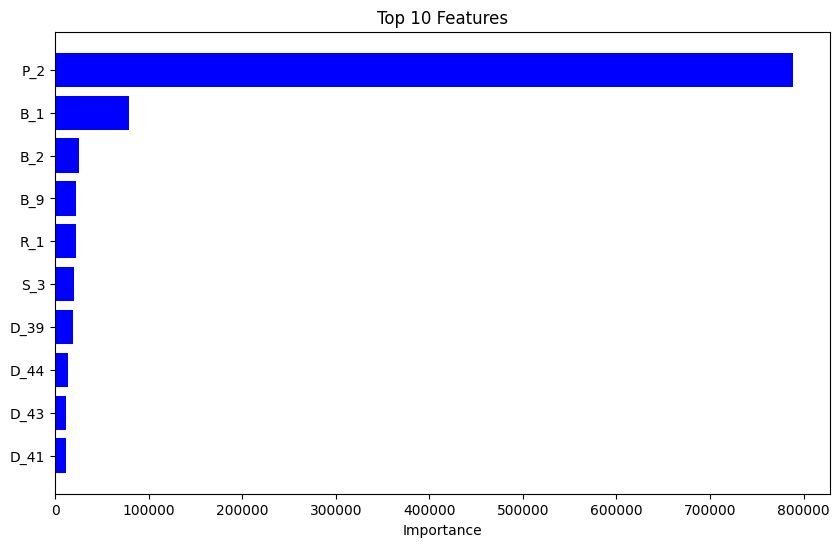

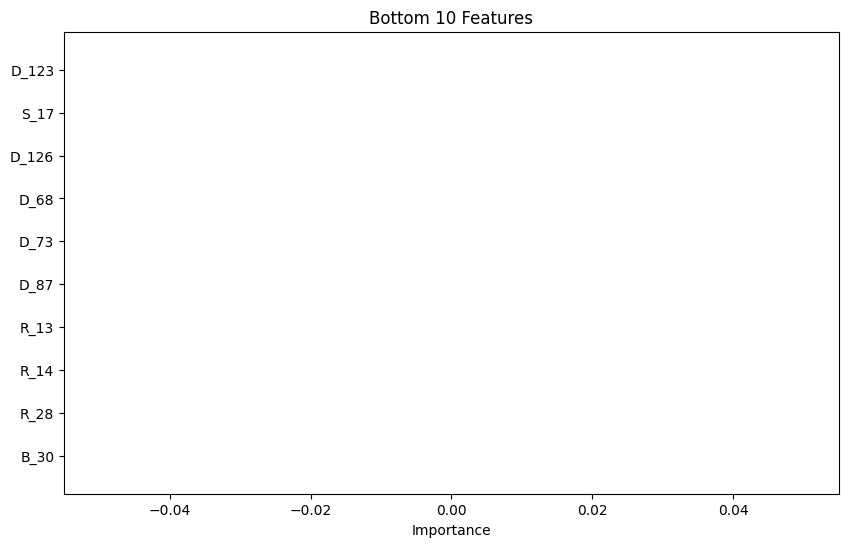

In [54]:

feature_df=calculate_lgbm_feature_importance(X_train, y_train, X_test, y_test, X_validation, y_validation)


In [55]:
feature_df.sort_values(by='importance').head(150)

,feature,importance
23,B_30,0.000000
54,D_116,0.000000
61,D_123,0.000000
172,S_17,0.000000
64,D_126,0.000000
...,...,...
108,D_65,1191.392473
59,D_121,1212.796089
183,S_5,1349.616512
185,S_7,1363.387680


In [56]:
# Select features with importance less than 100
features_importance_lt_100 = feature_df[feature_df['importance'] < 100]['feature'].tolist()

# Select features with importance less than 1000
features_importance_lt_1000 = feature_df[feature_df['importance'] < 1000]['feature'].tolist()


In [57]:
len(features_importance_lt_100),len(features_importance_lt_1000)

(61, 140)

In [58]:
feature_df.shape,na_df.shape

((189, 2), (190, 5))

In [59]:
feature_df.head(140),na_df.head()

(    feature     importance
 136     P_2  788859.698977
 0       B_1   78757.070644
 11      B_2   25162.200268
 39      B_9   22674.654642
 139     R_1   21914.308102
 ..      ...            ...
 149    R_19      86.074303
 176    S_22      83.202700
 181    S_27      82.541899
 65    D_127      81.611799
 130    D_89      81.259399
 
 [140 rows x 2 columns],
       Column Data_Type  Missing_Values  Missing_Count  unique_val_count
 D_88    D_88   float16            True       0.998198               771
 D_108  D_108   float16            True       0.994276              1719
 D_111  D_111   float16            True       0.991985               168
 D_110  D_110   float16            True       0.991985              1278
 B_39    B_39   float16            True       0.991055              2465)

In [60]:
# Merge feature_df and na_df on the 'feature' column
merged_df = feature_df.merge(na_df[['Column', 'Missing_Count','Data_Type', 'unique_val_count']], left_on='feature', right_index=True, how='left')

# Display the merged dataframe
merged_df.head()


,feature,importance,Column,Missing_Count,Data_Type,unique_val_count
136,P_2,788859.698977,P_2,0.006470,float16,11356
0,B_1,78757.070644,B_1,0.000000,float16,14360
11,B_2,25162.200268,B_2,0.000068,float16,11988
39,B_9,22674.654642,B_9,0.000000,float16,15857
139,R_1,21914.308102,R_1,0.000000,float16,8395


In [61]:
merged_df.sort_values(by='importance').reset_index().head()


,index,feature,importance,Column,Missing_Count,Data_Type,unique_val_count
0,23,B_30,0.0,B_30,0.000000,int8,4
1,54,D_116,0.0,D_116,0.000000,int8,3
2,61,D_123,0.0,D_123,0.013111,float16,8327
3,172,S_17,0.0,S_17,0.000000,float16,16175
4,64,D_126,0.0,D_126,0.000000,int8,2


In [62]:
merged_df.sort_values(by='Missing_Count',ascending=False).head(30)


,feature,importance,Column,Missing_Count,Data_Type,unique_val_count
129,D_88,21.225700,D_88,0.998198,float16,771
46,D_108,124.720699,D_108,0.994276,float16,1719
48,D_110,266.058199,D_110,0.991985,float16,1278
49,D_111,67.081100,D_111,0.991985,float16,168
30,B_39,879.278399,B_39,0.991055,float16,2465
115,D_73,0.000000,D_73,0.990763,float16,2796
34,B_42,19.693001,B_42,0.986616,float16,4329
72,D_134,162.452501,D_134,0.964274,float16,4911
75,D_137,154.068600,D_137,0.964274,float16,4402
74,D_136,93.043001,D_136,0.964274,float16,2511


In [63]:
#lets perform modelling by dropping features upto 100 importance which is .0127% of highest 
#importance ie 788859.69
# Create new variables with filtered data
X_train_100 = X_train.drop(features_importance_lt_100, axis=1).copy()
X_test_100 = X_test.drop(features_importance_lt_100, axis=1).copy()
X_validation_100 = X_validation.drop(features_importance_lt_100, axis=1).copy()

In [64]:
from sklearn.impute import KNNImputer

def knn_impute(df, n_neighbors=5):
    # Create a KNN imputer object
    imputer = KNNImputer(n_neighbors=n_neighbors)
    
    # Fit the imputer on the DataFrame and transform it
    imputed_data = imputer.fit_transform(df)
    
    # Convert the imputed data back to a DataFrame
    imputed_df = pd.DataFrame(imputed_data, columns=df.columns)
    
    return imputed_df


Owing to the fact that even after running the notebook for more than 6 hours the KNN imputation did not work, we are stopping the EDA here due to GPU and RAM limitation

In [65]:
# Impute missing values in selected features for train, test, and validation sets
#X_train_100_imputed = knn_impute(X_train_100, 10)
#X_test_100_imputed = knn_impute(X_test_100, 10)
#X_validation_100_imputed = knn_impute(X_validation_100, 10)